# PROJECT 4: Exotic searches with ATLAS and ML Classification

In [1]:
# Standard import(s)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn.metrics import ConfusionMatrixDisplay
import os
from sklearn import model_selection , preprocessing 
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dropout
from iminuit import Minuit
from scipy import integrate
from scipy.stats import chi2
from scipy.special import erfinv
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from sklearn.metrics import roc_curve

## Input files and Setup

First thing I'm going to check is the size of the files just to know if things might take long to run/prcess or not.

In [3]:
print(os.path.getsize("Diboson.csv"))
print(os.path.getsize("Top.csv"))
print(os.path.getsize("ggH1000.csv"))
print(os.path.getsize("Zjets.csv"))

33688877
19556027
10883859
1401889930


The last background data file ("Zjets.csv") is much larger than the rest, so it will take much longer to process and run when used

The variables we will focus on for this project are contained in the variables list:

In [4]:
# variables that we are interested in:
variables = ['lep1_pt','lep2_pt','fatjet_pt','fatjet_eta','fatjet_D2','Zll_mass','Zll_pt','MET','reco_zv_mass','isSignal', 'FullEventWeight']

Then reading the .csv files into pandas dataframes (data-cleanning the NaN values and doing a sanity check of the data frame by doing df.head() to see that the variables we are interested in are there):

In [5]:
data_diboson = pd.read_csv('Diboson.csv')
print(data_diboson.isna().sum().sum())
data_diboson.head()

0


,Unnamed: 0,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,0,0.387345,41920.540,0,187549.810,374316.600,0.127114,1.786927,353161.47,-0.001591,...,1.677279,-1.346853,369495.34,12147.315,1,-0.686657,-2.412152,9755.2705,1014320.10,-1.0
1,1,0.172328,225618.530,0,13106.807,51429.535,0.269517,2.296220,357617.66,-1.066937,...,-2.057147,2.975854,36972.74,34980.440,-1,-1.521354,2.819377,14584.7360,240295.97,-1.0
2,2,0.371392,42284.125,0,84519.230,153790.270,0.051175,3.360730,345472.30,0.704825,...,-0.285897,-0.084159,146895.95,24618.990,-1,0.741342,1.177780,19119.7030,471285.40,-1.0
3,3,0.309902,42735.938,1,76138.640,102611.836,0.117028,0.702838,476446.80,0.095546,...,-0.160614,-2.544057,109699.72,22303.861,1,-1.648011,1.120479,8277.4480,495503.10,-1.0
4,4,0.202772,70475.780,0,86138.000,141886.280,0.053951,3.634348,799487.75,-1.828396,...,-0.499056,0.429884,151453.40,14053.401,-1,-0.171763,2.796952,13848.2230,498823.40,-1.0


In [6]:
data_diboson = data_diboson[variables]
data_diboson.head()

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,369495.34,9755.2705,345940.12,-0.001591,1.786927,187549.810,374316.600,41920.540,1014320.10,0,0.387345
1,36972.74,14584.7360,218057.10,-1.066937,2.296220,13106.807,51429.535,225618.530,240295.97,0,0.172328
2,146895.95,19119.7030,274339.25,0.704825,3.360730,84519.230,153790.270,42284.125,471285.40,0,0.371392
3,109699.72,8277.4480,444837.44,0.095546,0.702838,76138.640,102611.836,42735.938,495503.10,0,0.309902
4,151453.40,13848.2230,250422.77,-1.828396,3.634348,86138.000,141886.280,70475.780,498823.40,0,0.202772


That looks fine, so I'm going to repeat the same procedure for all data sets:

In [7]:
data_top = pd.read_csv("Top.csv")
data_top = data_top[variables]
data_top.dropna(inplace = True)
print(data_top.isna().sum().sum())
data_top.head()


0


,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,38513.980,9003.888,253407.78,-1.195378,1.435712,35253.492,35612.324,51609.760,245723.92,0,2.004522e-09
1,34191.734,9425.637,256178.67,0.387434,2.403266,20311.205,38644.793,225038.800,351938.88,0,1.822626e-09
2,254871.310,17218.764,282584.72,-1.822714,1.336584,134715.500,244261.840,27090.697,1046120.90,0,1.552981e-09
3,84608.050,9801.820,205555.95,-1.725750,1.780693,69086.836,90045.625,57572.890,301995.70,0,1.660535e-09
4,50720.953,10932.975,256003.56,1.477704,3.398984,51731.508,52780.684,123177.900,376986.28,0,1.461494e-09


In [8]:
data_gg = pd.read_csv("ggH1000.csv")
data_gg = data_gg[variables]
data_gg.dropna(inplace = True)
print(data_gg.isna().sum().sum())
data_gg.head()

0


,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,320104.62,312638.44,480641.84,-0.851387,0.889354,87475.55,627990.80,44495.770,1063465.80,1,0.013603
1,288589.78,129548.62,375352.78,1.041311,1.485706,90507.31,409780.94,34441.156,974210.75,1,0.242178
2,228625.23,118590.28,555879.20,0.417858,1.219367,89765.85,344668.30,21625.379,996837.40,1,0.096412
3,302502.84,233439.89,430646.20,0.438590,0.592705,92313.63,535629.06,21855.973,989655.56,1,0.096373
4,224785.02,76205.98,244348.40,1.213717,0.724910,89451.92,296257.47,33677.380,993398.30,1,0.073052


In [9]:
data_zjets = pd.read_csv("Zjets.csv")
data_zjets = data_zjets[variables]
data_zjets.dropna(inplace = True)
print(data_zjets.isna().sum().sum())
data_zjets.head()

0


,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,76128.370,11973.011,210397.60,-1.329446,1.895164,95697.766,64252.690,177227.420,596020.44,0,-0.790471
1,40799.945,27624.867,226681.30,-0.429050,0.000000,90289.914,32506.705,10660.757,260357.19,0,0.789204
2,57988.660,27102.590,547212.70,-0.543789,2.463149,92994.430,55287.625,655334.400,422698.44,0,-0.872639
3,55424.742,51873.030,200684.47,1.776149,2.081222,89607.580,63405.484,41489.973,302718.06,0,-0.772697
4,68312.220,28290.979,324990.97,-1.524169,2.321676,90199.480,47187.332,41731.630,461896.25,0,1.581337


All the data sets now loaded into pandas data frames look fine, so I can start setting up everything.

The next step then is to plot the kinematic distribution of each process. I plot all of them before any cuts to then be able to compare then before and after the cuts. (In the plots to make it easier for the eye the signal is plot with a warm colour (pink) and the backlground entries with cold colours (blue, purple, green).

In [10]:
lim_down = np.array([0,0,0,-3,0,0,0,0,0])
lim_up = np.array([0.8e6, 0.4e6, 1e6, 3, 7.5,0.3e6, 0.8e6, 0.5e6, 3e6])

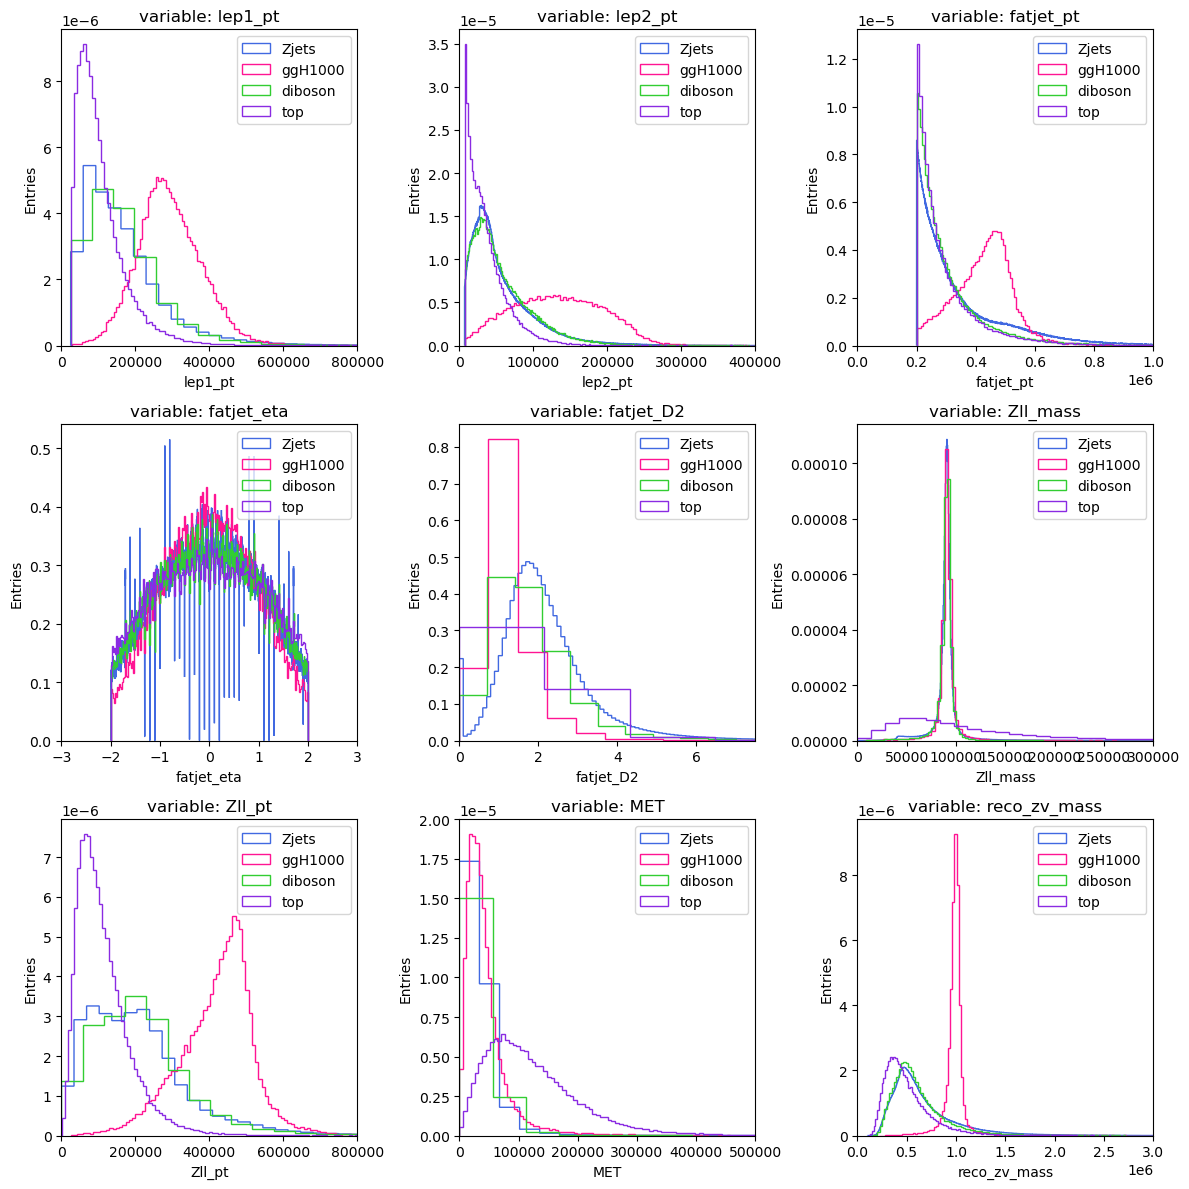

In [11]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace =0.2)
for i in range(1,10):
        ax = fig.add_subplot(3,3,i)
        ax.hist(data_zjets[variables[i-1]], bins = 10000,  label='Zjets',histtype=u'step', density = True, color = "royalblue")
        ax.hist(data_gg[variables[i-1]], bins = 200,  label='ggH1000',histtype=u'step', density = True, color = "deeppink")
        ax.hist(data_diboson[variables[i-1]], bins = 500, label='diboson',histtype=u'step', density = True, color = "limegreen")
        ax.hist(data_top[variables[i-1]], bins = 200, label = "top",histtype=u'step', density = True, color = "blueviolet")
        ax.legend(loc='upper right')
        ax.set_xlim((lim_down[i-1], lim_up[i-1]))
        ax.set_title("variable: " + str(variables[i-1]))
        ax.set_ylabel("Entries")
        ax.set_xlabel(str(variables[i-1]))
fig.tight_layout()

Ill be working one by one variable, plotting it and then doing the cuts for that variable. Taking into account the *word of caution* given in the instructions that says that the harder you cut onthese variables, the more difficult it will be to model the background distribution in the next section. Also I read this referece [1] in order to know how to perform ok cuts. (Basically selection of data *entries*)

For the *lep1_pt* variable it seems sensible to use a cut of lept1_pt > 150000 to not get rid of too much signal.

In [12]:
data_gg.describe()

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
count,5.001300e+04,50013.000000,5.001300e+04,50013.000000,50013.000000,50013.000000,5.001300e+04,5.001300e+04,5.001300e+04,50013.0,50013.000000
mean,2.926382e+05,133158.631408,4.271568e+05,0.001742,1.283203,91828.218539,4.200331e+05,4.410757e+04,9.902443e+05,1.0,0.083981
std,8.986758e+04,61258.916152,1.024379e+05,0.921542,1.292750,19548.871645,1.041247e+05,4.118627e+04,1.357657e+05,0.0,0.051589
min,2.839228e+04,7000.380400,2.001022e+05,-1.999975,0.000000,5424.894000,2.471575e+04,1.894245e+02,2.210946e+05,1.0,0.000027
25%,2.342062e+05,86009.840000,3.614212e+05,-0.691443,0.871743,88252.330000,3.599878e+05,2.059808e+04,9.567398e+05,1.0,0.068747
50%,2.854656e+05,131641.550000,4.347741e+05,-0.000919,1.135249,90866.210000,4.334945e+05,3.398209e+04,9.915921e+05,1.0,0.072111
75%,3.468808e+05,178317.300000,4.884303e+05,0.686425,1.472331,93441.120000,4.827581e+05,5.314014e+04,1.019936e+06,1.0,0.077223
max,1.440719e+06,707777.800000,1.663566e+06,1.999873,147.475800,698900.250000,1.774344e+06,1.077027e+06,4.462604e+06,1.0,0.800399


In [13]:
# lept1_pt cut:
data_gg_cut = data_gg[data_gg.lep1_pt > 150000]

I create new data frames for the "cut" data sets from here.

In [14]:
# (double check to see that we are taking values from all the events)
data_gg_cut.describe()

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
count,4.789400e+04,47894.000000,4.789400e+04,47894.000000,47894.000000,47894.000000,4.789400e+04,4.789400e+04,4.789400e+04,47894.0,47894.000000
mean,3.003306e+05,135553.628259,4.304299e+05,0.002242,1.279612,92417.577782,4.303129e+05,4.273089e+04,9.962614e+05,1.0,0.083997
std,8.370029e+04,61062.426039,9.922237e+04,0.910429,1.274861,18957.088492,9.319232e+04,3.654152e+04,1.288942e+05,0.0,0.051520
min,1.500108e+05,7004.987300,2.001022e+05,-1.999446,0.000000,13298.005000,8.603670e+04,1.894245e+02,3.393889e+05,1.0,0.000027
25%,2.411821e+05,88596.093750,3.675200e+05,-0.678645,0.873173,88395.311250,3.718502e+05,2.057047e+04,9.593820e+05,1.0,0.068701
50%,2.899593e+05,134913.110000,4.373102e+05,0.001422,1.135642,90920.785000,4.382331e+05,3.391556e+04,9.926693e+05,1.0,0.072116
75%,3.502452e+05,180645.182500,4.894867e+05,0.673865,1.469579,93519.478500,4.845545e+05,5.271870e+04,1.020713e+06,1.0,0.077349
max,1.440719e+06,707777.800000,1.663566e+06,1.999873,147.475800,698900.250000,1.774344e+06,1.077027e+06,4.462604e+06,1.0,0.800399


In [15]:
# lept1_pt cut:
data_zjets_cut = data_zjets[data_zjets.lep1_pt > 150000]
data_diboson_cut = data_diboson[data_diboson.lep1_pt > 150000]
data_top_cut = data_top[data_top.lep1_pt > 150000]

Histogram to see the changes after the cut:

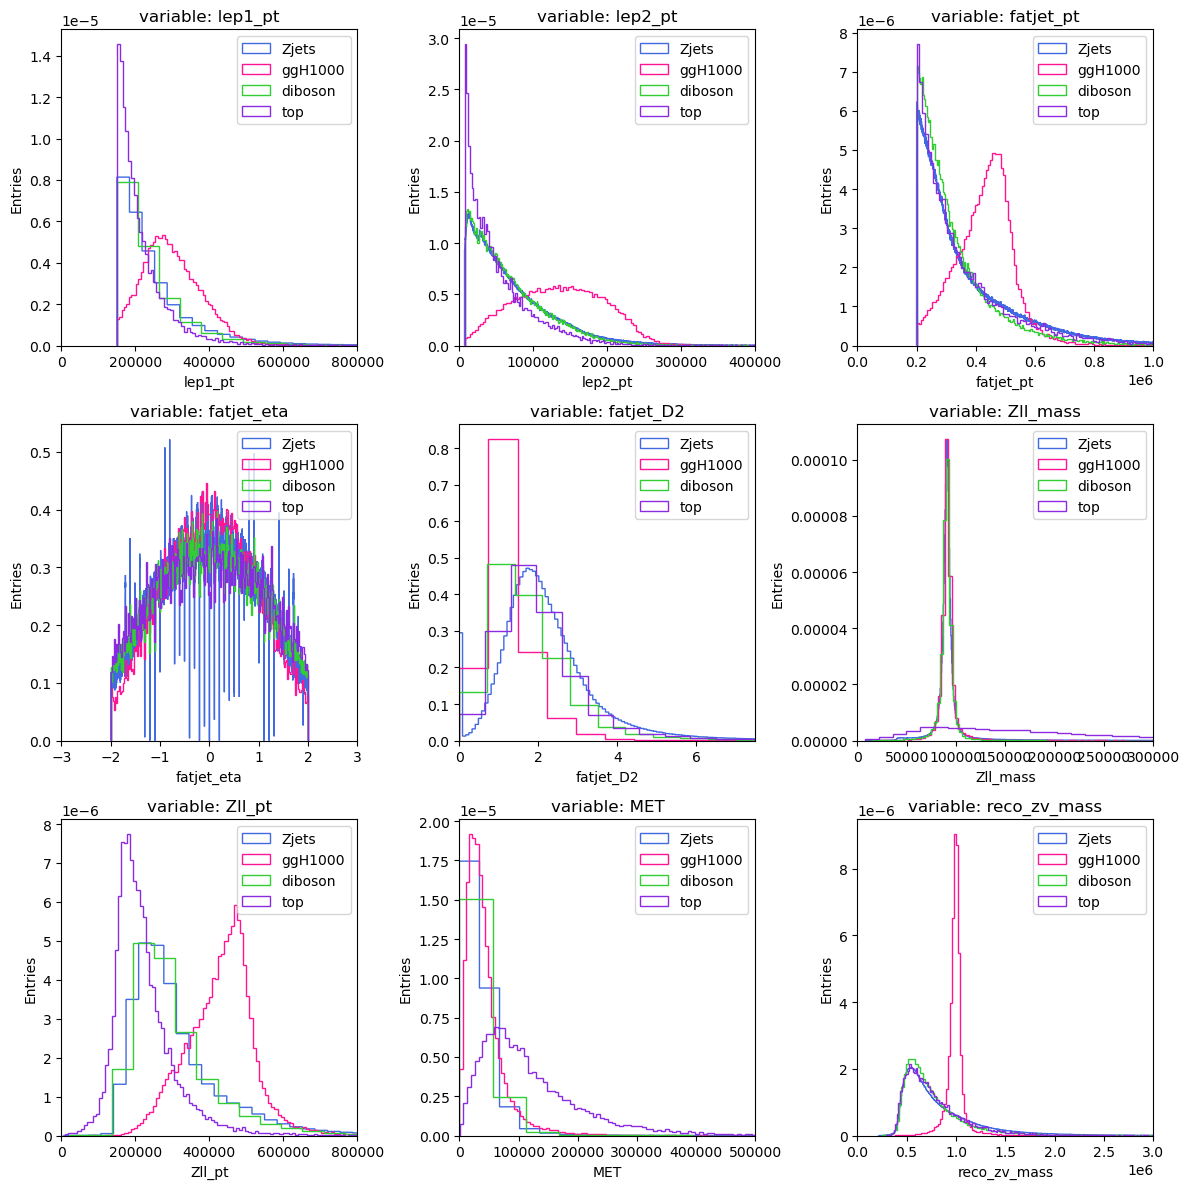

In [16]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace =0.2)
for i in range(1,10):
        ax = fig.add_subplot(3,3,i)
        ax.hist(data_zjets_cut[variables[i-1]], bins = 10000,  label='Zjets',histtype=u'step', density = True, color = "royalblue")
        ax.hist(data_gg_cut[variables[i-1]], bins = 200,  label='ggH1000',histtype=u'step', density = True, color = "deeppink")
        ax.hist(data_diboson_cut[variables[i-1]], bins = 500, label='diboson',histtype=u'step', density = True, color = "limegreen")
        ax.hist(data_top_cut[variables[i-1]], bins = 200, label = "top",histtype=u'step', density = True, color = "blueviolet")
        ax.legend(loc='upper right')
        ax.set_xlim((lim_down[i-1], lim_up[i-1]))
        ax.set_title("variable: " + str(variables[i-1]))
        ax.set_ylabel("Entries")
        ax.set_xlabel(str(variables[i-1]))
fig.tight_layout()


Ok that looks reasonable, so I'm going to do the same process for the rest of variables.

For the lep2_pt variable I don't see a straight forward cut to do in this one so I will only cut for lep2_pt > 30000 only for this variable to avoid over-cutting (that would get rif of a small chunk of top background).

In [17]:
# lep2_pt cut:
data_zjets_cut = data_zjets_cut[data_zjets_cut.lep2_pt > 30000]
data_diboson_cut = data_diboson_cut[data_diboson_cut.lep2_pt > 30000]
data_top_cut = data_top_cut[data_top_cut.lep2_pt > 30000]
data_gg_cut = data_gg_cut[data_gg_cut.lep2_pt > 30000]


Also, I keep replotting all the variables eventhought I'm cutting onw by one just to check that if after a cut the other variables change a bit.

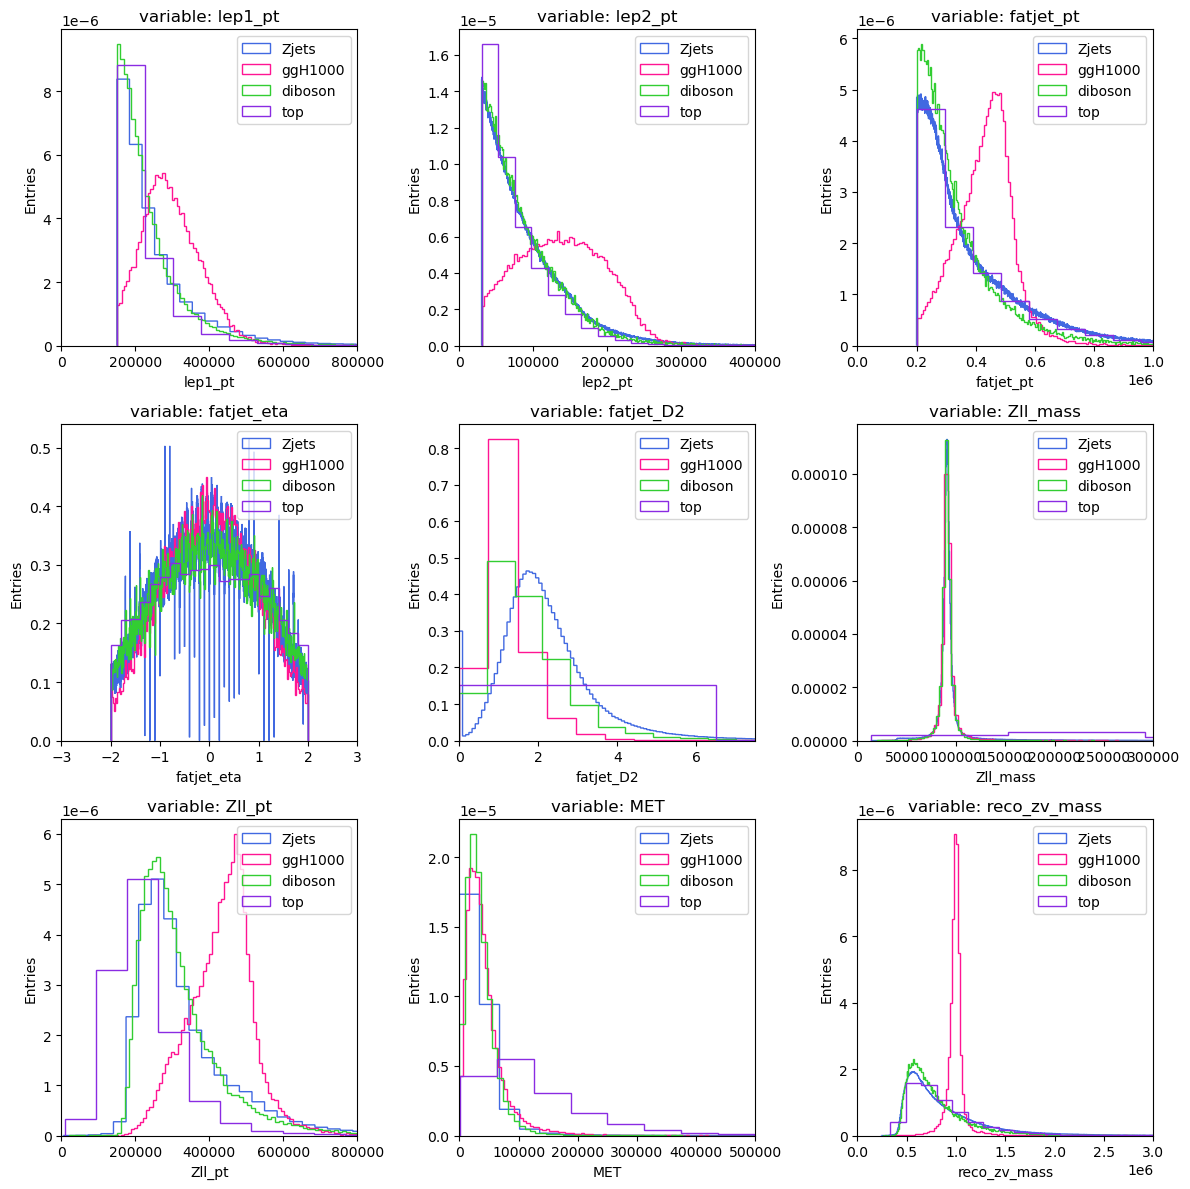

In [18]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace =0.2)
for i in range(1,10):
        ax = fig.add_subplot(3,3,i)
        ax.hist(data_zjets_cut[variables[i-1]], bins = 10000,  label='Zjets',histtype=u'step', density = True, color = "royalblue")
        ax.hist(data_gg_cut[variables[i-1]], bins = 200,  label='ggH1000',histtype=u'step', density = True, color = "deeppink")
        ax.hist(data_diboson_cut[variables[i-1]], bins = 500, label='diboson',histtype=u'step', density = True, color = "limegreen")
        ax.hist(data_top_cut[variables[i-1]], bins = 20, label = "top",histtype=u'step', density = True, color = "blueviolet")
        ax.legend(loc='upper right')
        ax.set_xlim((lim_down[i-1], lim_up[i-1]))
        ax.set_title("variable: " + str(variables[i-1]))
        ax.set_ylabel("Entries")
        ax.set_xlabel(str(variables[i-1]))
fig.tight_layout()

For the fatjet_pt variable I will use the cut fatjet_pt > 0.3e6 to avoid cutting too much signal.

In [19]:
# fatjet_pt cut:
data_zjets_cut = data_zjets_cut[data_zjets_cut.fatjet_pt > 0.3e6]
data_diboson_cut = data_diboson_cut[data_diboson_cut.fatjet_pt > 0.3e6]
data_top_cut = data_top_cut[data_top_cut.fatjet_pt > 0.3e6]
data_gg_cut = data_gg_cut[data_gg_cut.fatjet_pt > 0.3e6]

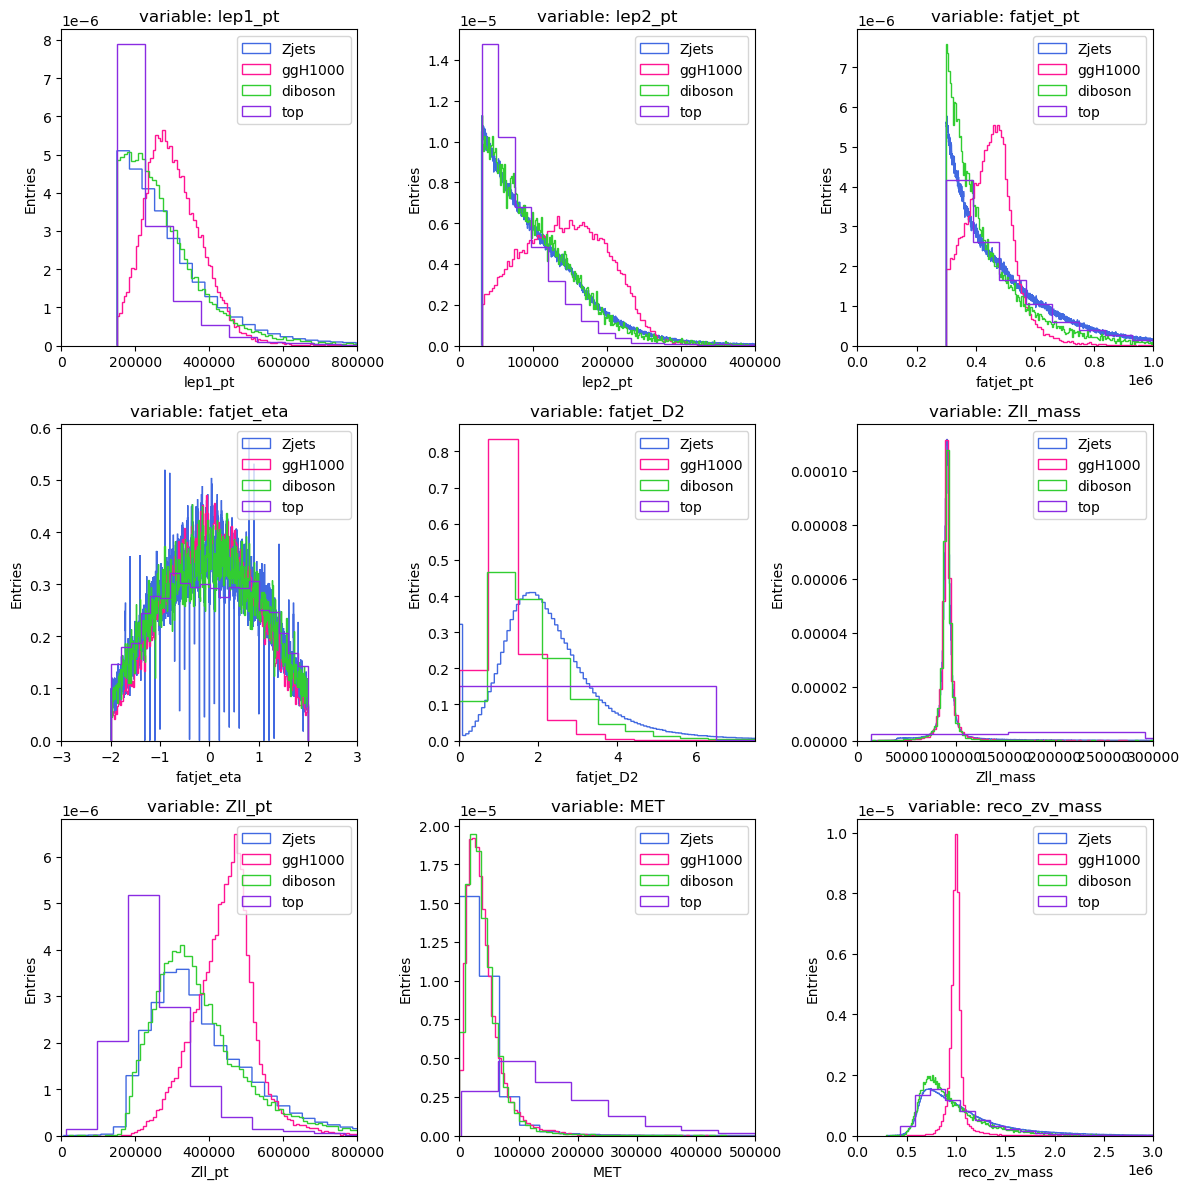

In [20]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace =0.2)
for i in range(1,10):
        ax = fig.add_subplot(3,3,i)
        ax.hist(data_zjets_cut[variables[i-1]], bins = 10000,  label='Zjets',histtype=u'step', density = True, color = "royalblue")
        ax.hist(data_gg_cut[variables[i-1]], bins = 200,  label='ggH1000',histtype=u'step', density = True, color = "deeppink")
        ax.hist(data_diboson_cut[variables[i-1]], bins = 500, label='diboson',histtype=u'step', density = True, color = "limegreen")
        ax.hist(data_top_cut[variables[i-1]], bins = 20, label = "top",histtype=u'step', density = True, color = "blueviolet")
        ax.legend(loc='upper right')
        ax.set_xlim((lim_down[i-1], lim_up[i-1]))
        ax.set_title("variable: " + str(variables[i-1]))
        ax.set_ylabel("Entries")
        ax.set_xlabel(str(variables[i-1]))
fig.tight_layout()

For the fatjet_eta variable there are no sensibles cut I can make.

For the fatjet_D2 The cut for this variable will be: fatjet_D2 < 3 and fatjet_D2 > 0.1.

In [21]:
# fatjet_D2 cut:
data_zjets_cut = data_zjets_cut[data_zjets_cut.fatjet_D2 < 3]
data_diboson_cut = data_diboson_cut[data_diboson_cut.fatjet_D2 < 3]
data_top_cut = data_top_cut[data_top_cut.fatjet_D2 < 3]
data_gg_cut = data_gg_cut[data_gg_cut.fatjet_D2 < 3]

In [22]:
# fatjet_D2 cut:
data_zjets_cut = data_zjets_cut[data_zjets_cut.fatjet_D2 > 0.1]
data_diboson_cut = data_diboson_cut[data_diboson_cut.fatjet_D2 > 0.1]
data_top_cut = data_top_cut[data_top_cut.fatjet_D2 > 0.1]
data_gg_cut = data_gg_cut[data_gg_cut.fatjet_D2 > 0.1]

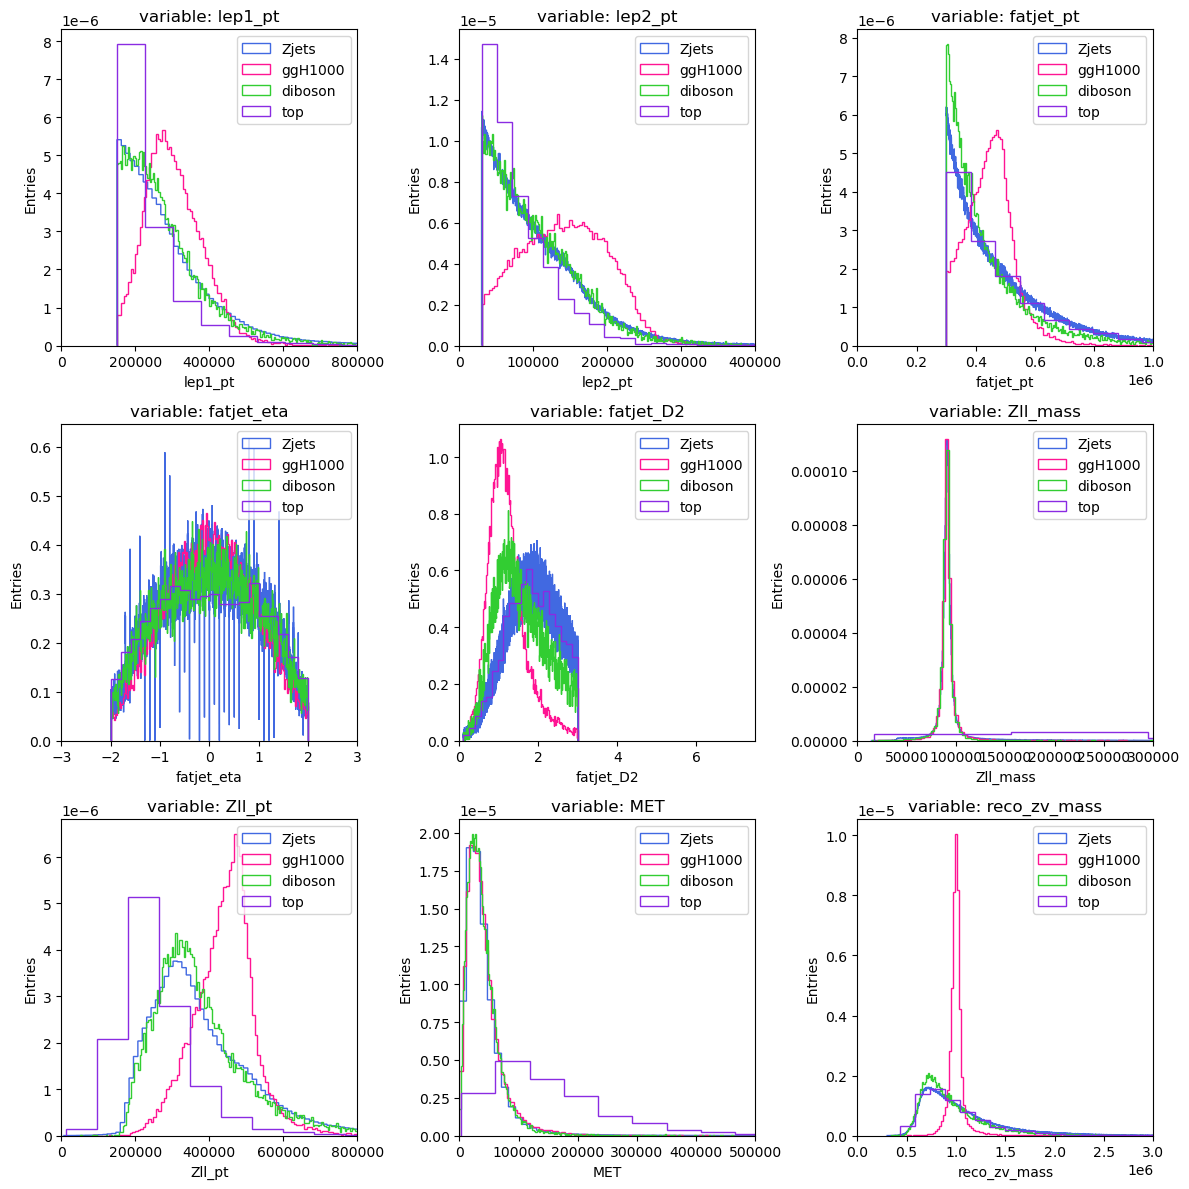

In [23]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace =0.2)
for i in range(1,10):
        ax = fig.add_subplot(3,3,i)
        ax.hist(data_zjets_cut[variables[i-1]], bins = 10000,  label='Zjets',histtype=u'step', density = True, color = "royalblue")
        ax.hist(data_gg_cut[variables[i-1]], bins = 200,  label='ggH1000',histtype=u'step', density = True, color = "deeppink")
        ax.hist(data_diboson_cut[variables[i-1]], bins = 500, label='diboson',histtype=u'step', density = True, color = "limegreen")
        ax.hist(data_top_cut[variables[i-1]], bins = 20, label = "top",histtype=u'step', density = True, color = "blueviolet")
        ax.legend(loc='upper right')
        ax.set_xlim((lim_down[i-1], lim_up[i-1]))
        ax.set_title("variable: " + str(variables[i-1]))
        ax.set_ylabel("Entries")
        ax.set_xlabel(str(variables[i-1]))
fig.tight_layout()

For the Zll_mass variable: This cut is very significant for the top background data set, the cut will be: 72000 < Zll_mass < 115000.

In [24]:
# Zll_mass cut:
data_zjets_cut = data_zjets_cut[data_zjets_cut.Zll_mass < 115000]
data_diboson_cut = data_diboson_cut[data_diboson_cut.Zll_mass < 115000]
data_top_cut = data_top_cut[data_top_cut.Zll_mass < 115000]
data_gg_cut = data_gg_cut[data_gg_cut.Zll_mass < 115000]

In [25]:
# Zll_mass cut:
data_zjets_cut = data_zjets_cut[data_zjets_cut.Zll_mass > 72000]
data_diboson_cut = data_diboson_cut[data_diboson_cut.Zll_mass > 72000]
data_top_cut = data_top_cut[data_top_cut.Zll_mass > 72000]
data_gg_cut = data_gg_cut[data_gg_cut.Zll_mass > 72000]

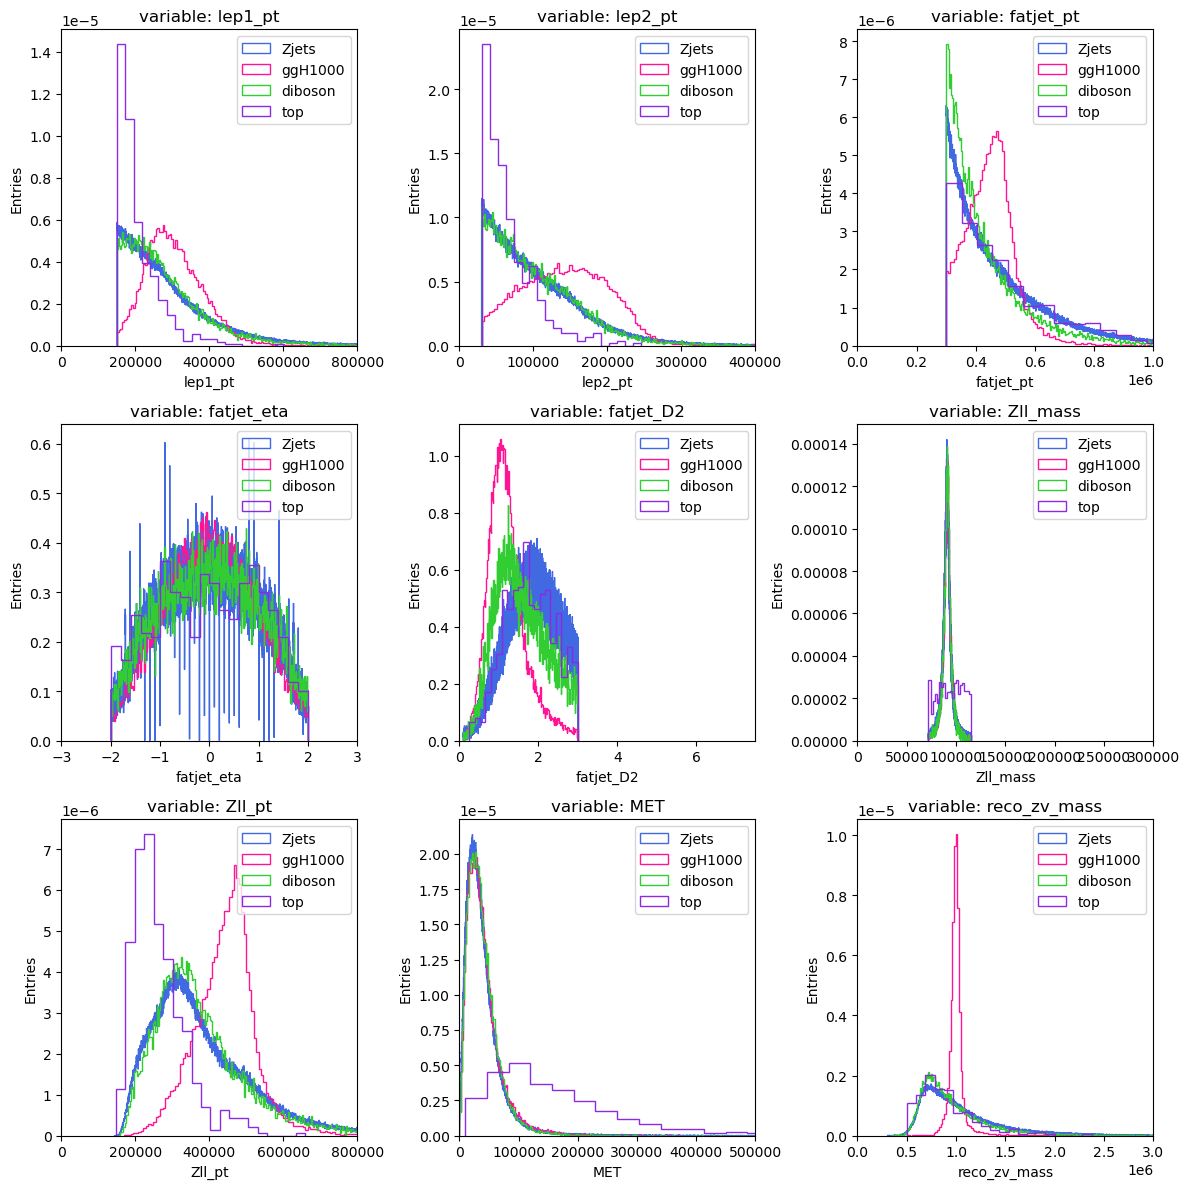

In [26]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace =0.2)
for i in range(1,10):
        ax = fig.add_subplot(3,3,i)
        ax.hist(data_zjets_cut[variables[i-1]], bins = 10000,  label='Zjets',histtype=u'step', density = True, color = "royalblue")
        ax.hist(data_gg_cut[variables[i-1]], bins = 200,  label='ggH1000',histtype=u'step', density = True, color = "deeppink")
        ax.hist(data_diboson_cut[variables[i-1]], bins = 500, label='diboson',histtype=u'step', density = True, color = "limegreen")
        ax.hist(data_top_cut[variables[i-1]], bins = 20, label = "top",histtype=u'step', density = True, color = "blueviolet")
        ax.legend(loc='upper right')
        ax.set_xlim((lim_down[i-1], lim_up[i-1]))
        ax.set_title("variable: " + str(variables[i-1]))
        ax.set_ylabel("Entries")
        ax.set_xlabel(str(variables[i-1]))
fig.tight_layout()

Now in the histograms (after the Zll_mass cut) we can see the huge reduction in top entries.

For the Zll_pt variable I'm going to perform the cut: 700000 > Zll_pt > 270000:

In [27]:
# Zll_pt cut:
data_zjets_cut = data_zjets_cut[data_zjets_cut.Zll_pt > 270000]
data_diboson_cut = data_diboson_cut[data_diboson_cut.Zll_pt > 270000]
data_top_cut = data_top_cut[data_top_cut.Zll_pt > 270000]
data_gg_cut = data_gg_cut[data_gg_cut.Zll_pt > 270000]

In [28]:
# Zll_pt cut:
data_zjets_cut = data_zjets_cut[data_zjets_cut.Zll_pt < 700000]
data_diboson_cut = data_diboson_cut[data_diboson_cut.Zll_pt < 700000]
data_top_cut = data_top_cut[data_top_cut.Zll_pt < 700000]
data_gg_cut = data_gg_cut[data_gg_cut.Zll_pt < 700000]

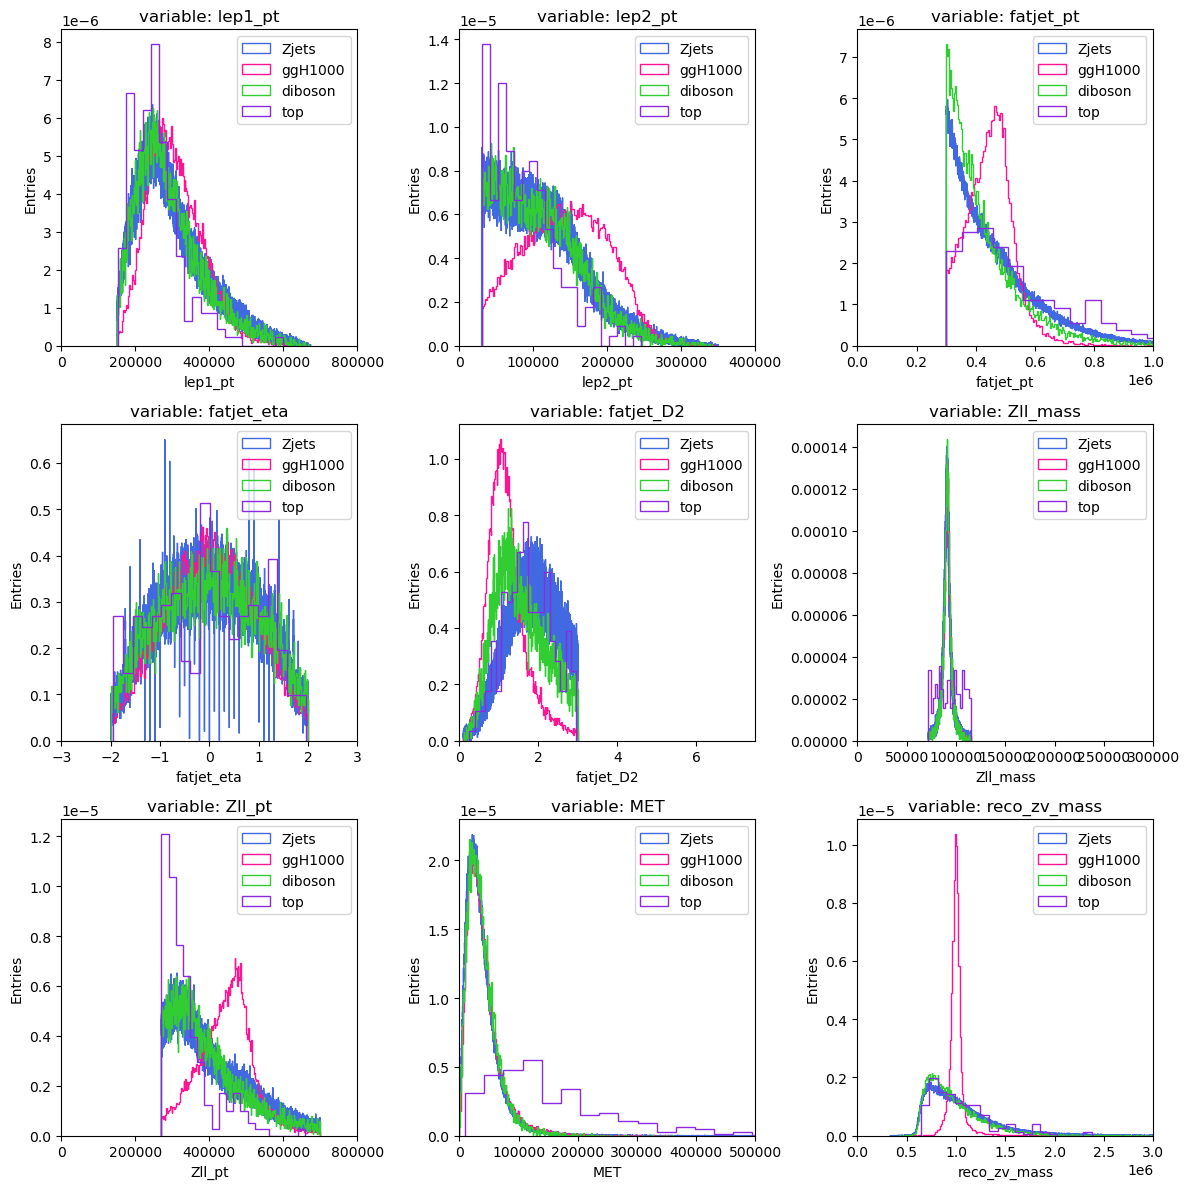

In [29]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace =0.2)
for i in range(1,10):
        ax = fig.add_subplot(3,3,i)
        ax.hist(data_zjets_cut[variables[i-1]], bins = 10000,  label='Zjets',histtype=u'step', density = True, color = "royalblue")
        ax.hist(data_gg_cut[variables[i-1]], bins = 200,  label='ggH1000',histtype=u'step', density = True, color = "deeppink")
        ax.hist(data_diboson_cut[variables[i-1]], bins = 500, label='diboson',histtype=u'step', density = True, color = "limegreen")
        ax.hist(data_top_cut[variables[i-1]], bins = 20, label = "top",histtype=u'step', density = True, color = "blueviolet")
        ax.legend(loc='upper right')
        ax.set_xlim((lim_down[i-1], lim_up[i-1]))
        ax.set_title("variable: " + str(variables[i-1]))
        ax.set_ylabel("Entries")
        ax.set_xlabel(str(variables[i-1]))
fig.tight_layout()

For the MET variable the cut it is going to be MET < 100000.:

In [30]:
# MET cut:
data_zjets_cut = data_zjets_cut[data_zjets_cut.MET < 100000]
data_diboson_cut = data_diboson_cut[data_diboson_cut.MET < 100000]
data_top_cut = data_top_cut[data_top_cut.MET < 100000]
data_gg_cut = data_gg_cut[data_gg_cut.MET < 100000]


After all these cuts lets see how the reco_zv_mass (we do not apply cuts on this variable) and other variables plots look like: 

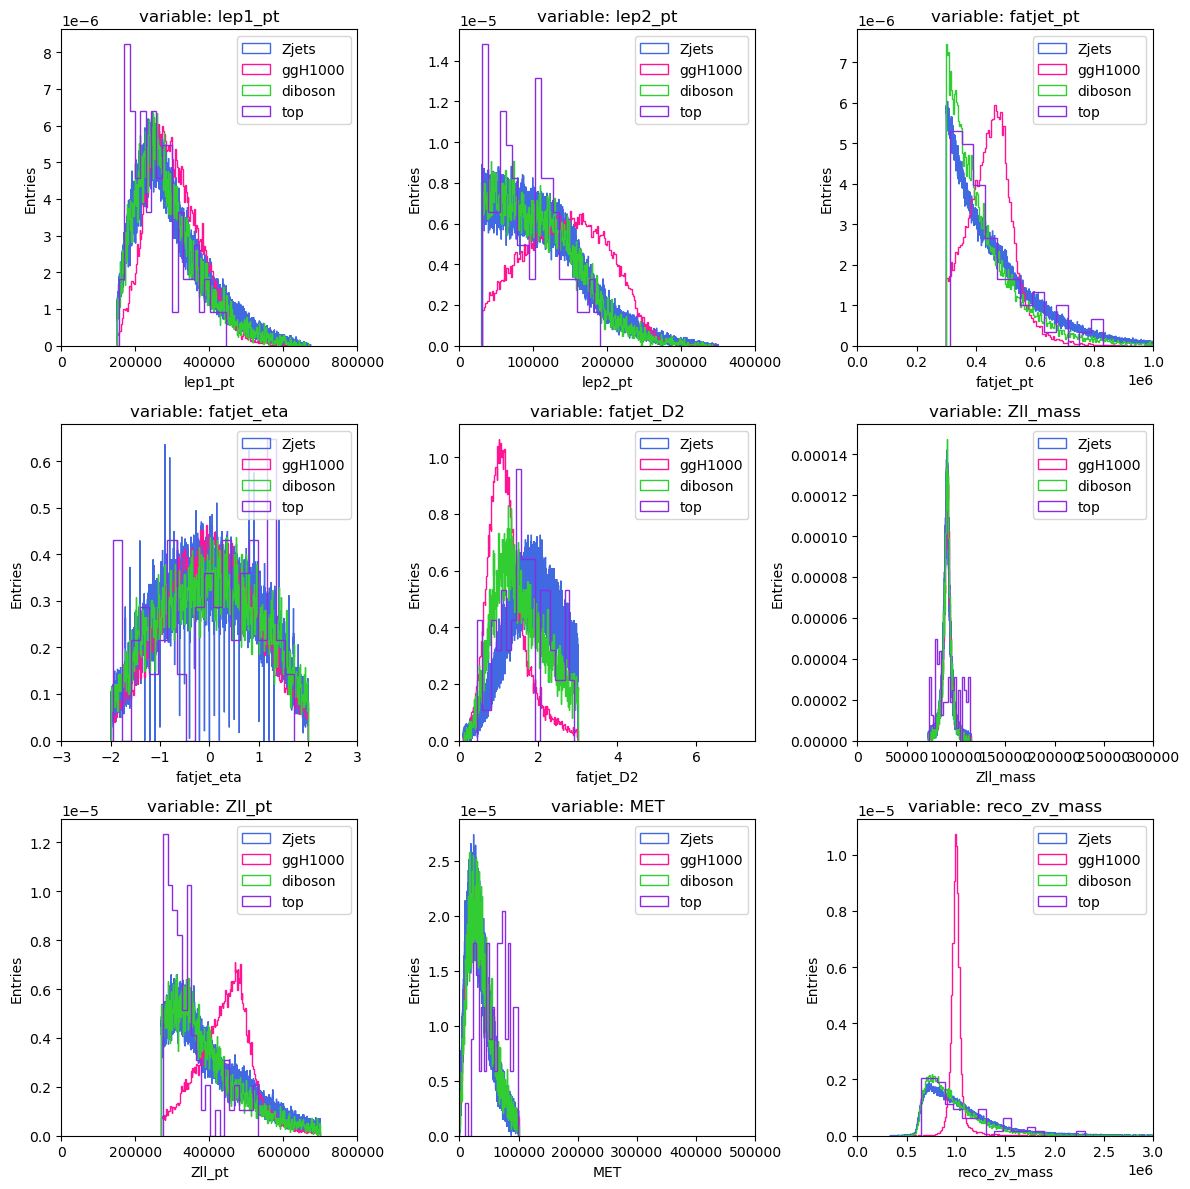

In [31]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace =0.2)
for i in range(1,10):
        ax = fig.add_subplot(3,3,i)
        ax.hist(data_zjets_cut[variables[i-1]], bins = 10000,  label='Zjets',histtype=u'step', density = True, color = "royalblue")
        ax.hist(data_gg_cut[variables[i-1]], bins = 200,  label='ggH1000',histtype=u'step', density = True, color = "deeppink")
        ax.hist(data_diboson_cut[variables[i-1]], bins = 500, label='diboson',histtype=u'step', density = True, color = "limegreen")
        ax.hist(data_top_cut[variables[i-1]], bins = 20, label = "top",histtype=u'step', density = True, color = "blueviolet")
        ax.legend(loc='upper right')
        ax.set_xlim((lim_down[i-1], lim_up[i-1]))
        ax.set_title("variable: " + str(variables[i-1]))
        ax.set_ylabel("Entries")
        ax.set_xlabel(str(variables[i-1]))
fig.tight_layout()

The histogram looks ok, but we can see how there's almost no top backround entries left. This might be a problem when using the NN as the model might not be the best with differentiating top events because there seem to be only a few but we will see.

We can also check the difference in entries compared to before the cuts:

In [32]:
data_top.describe()

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
count,9.241600e+04,92416.000000,9.241600e+04,92416.000000,92416.000000,9.241600e+04,9.241600e+04,9.241600e+04,9.241600e+04,92416.0,9.241600e+04
mean,1.061781e+05,37273.060518,2.997223e+05,-0.003129,2.056313,1.107964e+05,1.133768e+05,1.239924e+05,5.089901e+05,0.0,9.273525e-01
std,7.093264e+04,30005.182138,1.220958e+05,1.052899,2.939845,9.030464e+04,7.564739e+04,8.429245e+04,2.555622e+05,0.0,6.022005e-01
min,2.500188e+04,7000.233000,2.000015e+05,-1.999928,0.000000,1.630285e+00,8.795647e+02,1.421654e+02,1.141334e+05,0.0,-8.267483e-08
25%,5.835440e+04,16095.827500,2.222531e+05,-0.865159,1.312937,5.410748e+04,6.125256e+04,6.435490e+04,3.386874e+05,0.0,7.589213e-01
50%,8.807420e+04,29489.606000,2.583107e+05,-0.005011,1.799548,8.618398e+04,9.636226e+04,1.066845e+05,4.471412e+05,0.0,7.995661e-01
75%,1.328355e+05,48775.190500,3.297947e+05,0.851933,2.387945,1.391428e+05,1.464777e+05,1.636803e+05,6.075279e+05,0.0,8.721613e-01
max,1.662596e+06,479290.060000,2.093351e+06,1.999888,431.331760,2.786148e+06,1.689418e+06,1.283725e+06,3.467486e+06,0.0,9.638480e+00


In [33]:
data_top_cut.describe()

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
count,76.000000,76.000000,7.600000e+01,76.000000,76.000000,76.000000,76.000000,76.000000,7.600000e+01,76.0,7.600000e+01
mean,260184.350395,90691.780250,4.614898e+05,0.045014,1.687829,92502.511316,343596.980921,59508.546776,1.010216e+06,0.0,8.600143e-01
std,69367.305914,41386.335392,1.447900e+05,1.045174,0.631935,12419.256940,66214.395831,23762.715930,3.368966e+05,0.0,3.292962e-01
min,155203.770000,30544.936000,3.125772e+05,-1.949272,0.443751,72415.480000,274033.900000,9827.282000,6.421409e+05,0.0,5.005005e-08
25%,204740.572500,57343.817000,3.680556e+05,-0.790606,1.239112,82760.460000,295497.687500,39742.607250,7.628005e+05,0.0,7.694820e-01
50%,252185.680000,84820.210000,4.160196e+05,0.156392,1.648039,91638.448000,320431.580000,62660.986500,8.864255e+05,0.0,8.004657e-01
75%,298745.027500,120452.437500,5.245660e+05,0.953957,2.169139,102770.103750,359630.942500,78148.985000,1.171017e+06,0.0,8.298104e-01
max,443511.900000,190540.230000,1.107438e+06,1.713800,2.912257,114635.840000,530179.060000,99835.914000,2.303220e+06,0.0,2.863011e+00


Before the cuts data_top had 92416 entries and now it is 155.

In [34]:
data_gg.describe()

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
count,5.001300e+04,50013.000000,5.001300e+04,50013.000000,50013.000000,50013.000000,5.001300e+04,5.001300e+04,5.001300e+04,50013.0,50013.000000
mean,2.926382e+05,133158.631408,4.271568e+05,0.001742,1.283203,91828.218539,4.200331e+05,4.410757e+04,9.902443e+05,1.0,0.083981
std,8.986758e+04,61258.916152,1.024379e+05,0.921542,1.292750,19548.871645,1.041247e+05,4.118627e+04,1.357657e+05,0.0,0.051589
min,2.839228e+04,7000.380400,2.001022e+05,-1.999975,0.000000,5424.894000,2.471575e+04,1.894245e+02,2.210946e+05,1.0,0.000027
25%,2.342062e+05,86009.840000,3.614212e+05,-0.691443,0.871743,88252.330000,3.599878e+05,2.059808e+04,9.567398e+05,1.0,0.068747
50%,2.854656e+05,131641.550000,4.347741e+05,-0.000919,1.135249,90866.210000,4.334945e+05,3.398209e+04,9.915921e+05,1.0,0.072111
75%,3.468808e+05,178317.300000,4.884303e+05,0.686425,1.472331,93441.120000,4.827581e+05,5.314014e+04,1.019936e+06,1.0,0.077223
max,1.440719e+06,707777.800000,1.663566e+06,1.999873,147.475800,698900.250000,1.774344e+06,1.077027e+06,4.462604e+06,1.0,0.800399


In [35]:
data_gg_cut.describe()

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
count,36002.000000,36002.000000,3.600200e+04,36002.000000,36002.000000,36002.000000,36002.000000,36002.000000,3.600200e+04,36002.0,36002.000000
mean,304080.381300,143749.838056,4.511022e+05,-0.003155,1.195549,91018.694589,442963.473463,35912.661501,1.005583e+06,1.0,0.083751
std,72709.580786,56379.783064,7.846193e+04,0.876799,0.483037,5290.222563,72512.910188,21043.361998,8.925929e+04,0.0,0.050346
min,150127.840000,30025.281000,3.000023e+05,-1.999446,0.104285,72014.110000,270034.030000,189.424450,4.976248e+05,1.0,0.000027
25%,251042.190000,100337.847500,3.976281e+05,-0.646359,0.868180,88590.515500,395172.407500,19736.244000,9.712408e+05,1.0,0.068693
50%,295513.780000,144394.725000,4.516630e+05,-0.006239,1.122705,90878.545000,447648.280000,32155.954500,9.975228e+05,1.0,0.072139
75%,350552.250000,186166.965000,4.958816e+05,0.635438,1.430379,93161.105000,487724.080000,48378.162500,1.023101e+06,1.0,0.077371
max,639282.400000,344899.340000,1.342806e+06,1.999348,2.998829,114977.050000,699856.800000,99997.020000,3.008687e+06,1.0,0.800399


The signal data set has not been reduced that drastically (from 50013 to 32950 entries) so it should be ok to proceed with this cuts.

Now I will plot the *reco_zv_mass* variable, using the FullEventWeight variable to normalize the contributions of the entries (that way I will be plotting the actual *events* distribution and not the *entries* distribution. I will do this for all the background events combined and then all the signal events to then be able to compare the total number of bgn and signal events. (For before and after the cuts). I will calculate the number of events by calculating the area under the histogram for each, so I am not going to normalize the histograms.

First I do it for BEFORE the cuts to be able to compare:

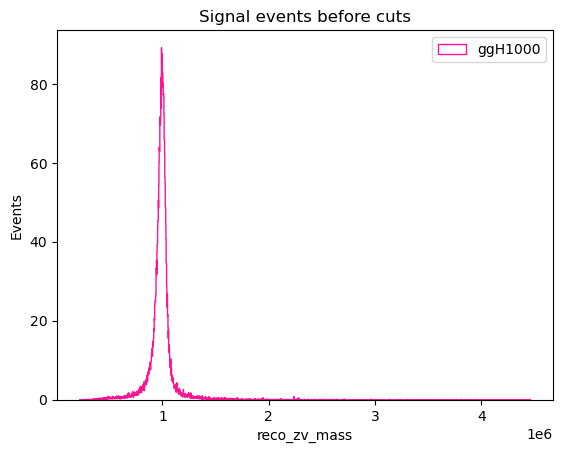

In [36]:
Sn, Sbins, Spatches = plt.hist(data_gg["reco_zv_mass"], bins = 2000,label='ggH1000',weights =data_gg["FullEventWeight"],color = "deeppink",histtype=u'step')
plt.legend(loc='upper right')
plt.title("Signal events before cuts")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

In [37]:
signal_beforecut = (Sbins[1] - Sbins[0])* sum(Sn)
print(signal_beforecut)

8907511.724466419


In [38]:
# combinnig all the background entries
combined = np.concatenate( (data_zjets, data_diboson, data_top) )
data_bgn = pd.DataFrame(combined, columns = variables)

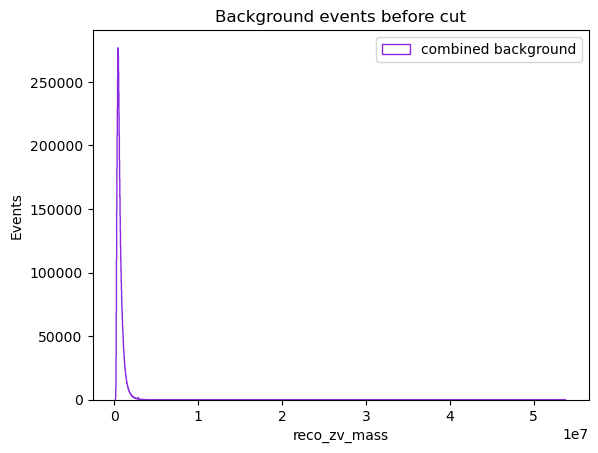

In [39]:
Bn, Bbins, Bpatches = plt.hist(data_bgn["reco_zv_mass"], bins = 2000,label='combined background',weights =data_bgn["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.legend(loc='upper right')
plt.title("Background events before cut")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

In [40]:
bgn_beforecut = (Bbins[1] - Bbins[0])* sum(Bn)
print(bgn_beforecut)

145133816778.4914


Now with AFTER the cuts data:

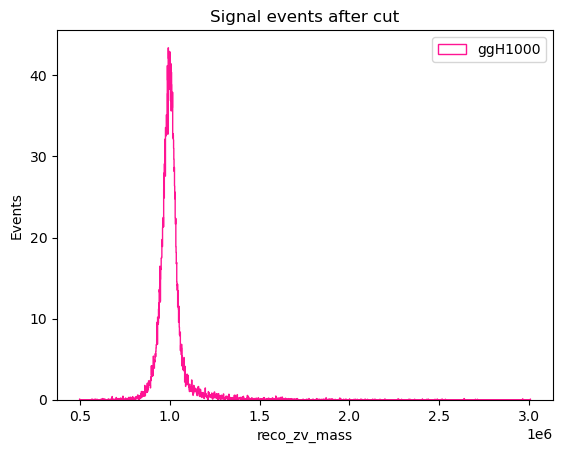

In [41]:
SAn, SAbins, SApatches = plt.hist(data_gg_cut["reco_zv_mass"], bins = 2000,label='ggH1000',weights =data_gg_cut["FullEventWeight"],color = "deeppink",histtype=u'step')
plt.legend(loc='upper right')
plt.title("Signal events after cut")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

In [42]:
signal_aftercut = (SAbins[1] - SAbins[0])* sum(SAn)
print(signal_aftercut)

3785689.3509021825


In [43]:
# combinnig all the background entries
combined_cut = np.concatenate( (data_zjets_cut, data_diboson_cut, data_top_cut) )
data_bgn_cut = pd.DataFrame(combined_cut, columns = variables)

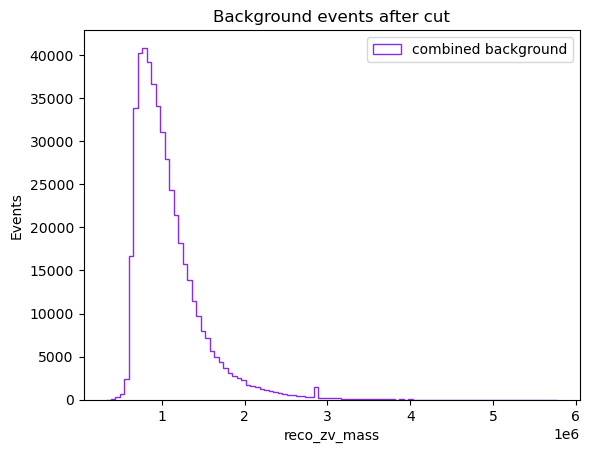

In [44]:
BAn, BAbins, BApatches = plt.hist(data_bgn_cut["reco_zv_mass"], bins = 100,label='combined background',weights =data_bgn_cut["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.legend(loc='upper right')
plt.title("Background events after cut")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

In [45]:
bgn_aftercut = (BAbins[1] - BAbins[0])* sum(BAn)
print(bgn_aftercut)

26139158530.428783


In [46]:
print("Signal events BEFORE cuts: " + str(signal_beforecut))
print("Signal events AFTER cuts: " + str(signal_aftercut))
print("Background events BEFORE cuts: " + str(bgn_beforecut))
print("background events AFTER cuts: " + str(bgn_aftercut))

Signal events BEFORE cuts: 8907511.724466419
Signal events AFTER cuts: 3785689.3509021825
Background events BEFORE cuts: 145133816778.4914
background events AFTER cuts: 26139158530.428783


In [47]:
print("Percentage of signal in total number of events:")
per_bef = signal_beforecut / (signal_beforecut + bgn_beforecut) * 100
print("Before cuts: " + str(per_bef) + "%")
per_af = signal_aftercut / (signal_aftercut + bgn_aftercut) * 100
print("After cuts: " + str(per_af) + "%")

Percentage of signal in total number of events:
Before cuts: 0.006137070781898559%
After cuts: 0.014480730705296535%


In [48]:
print("Cut efficiency for signal:")
sig_eff = signal_aftercut/signal_beforecut
print(sig_eff)

Cut efficiency for signal:
0.4249996483870982


In [49]:
print("Cut efficiency for background:")
bgn_eff = bgn_aftercut/bgn_beforecut
print(bgn_eff)

Cut efficiency for background:
0.1801038456138953


By looking at those numbers we can see how the percentage of signal within all the events is much larger after the cuts (went from 0.006% to 0.3%). At the same time the efficiencies for the cuts look ok, showing that I have kept half of the signal more or less but only 1% of the background.

**Posible sources of improvement for this section:** For this first "set-up" section one possible improvement is making sensible cuts by using the efficiency variable S / sqrt(S + B). By calculating this varible in different parts of the distribution and finding the maximum, where the masimum is it is where the cut should be made. 

## Fitting and Hypothesis testing

The next steps is to perform the modelling of the backgriound and the signal of the cutted events. First I'm going to model the background events with a second order polynomial.

In [50]:
bgn_range = data_bgn_cut[(data_bgn_cut["reco_zv_mass"] > 0.8e6) &(data_bgn_cut["reco_zv_mass"] < 1.4e6)]

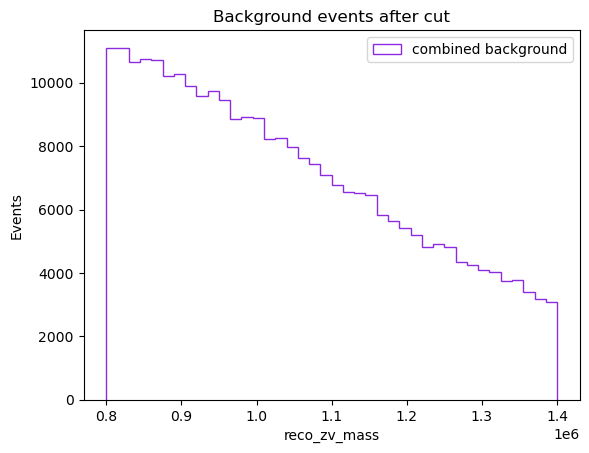

In [51]:
BAn, BAbins, BApatches = plt.hist(bgn_range["reco_zv_mass"] , bins = 40,label='combined background',weights =bgn_range["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.legend(loc='upper right')
plt.title("Background events after cut")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

In [52]:
Bxcenters = (BAbins[:-1] + BAbins[1:]) / 2

In [53]:
def first_poly (x, a, b):
    
    first_poly = a + b*x  
   
    
    return first_poly

In [54]:
def chi_first(a,b):
    
    z = np.sum((bgn_range["FullEventWeight"].values)**2)
    x = Bxcenters
    y = BAn
    
    
    return np.sum((y - first_poly(x,a,b))**2 / z )

In [55]:
# Estimate best value using Minuit

m_comb_0 = Minuit(chi_first, a = 1000, b = -100)

# m_comb_0.errordef = Minuit.LIKELIHOOD
m_comb_0.migrad()  # run optimiser
m_comb_0.hesse()   # run covariance estimator

print(m_comb_0.values)  # print estimated values
print(m_comb_0.errors)  # print error of the estimated values

<ValueView a=23208.51709060371 b=-0.014652910796250751>
<ErrorView a=849.4438311656637 b=0.0007628300093399063>


In [56]:
# min chi^2 value
print(m_comb_0.fval)

2.1775963656097104


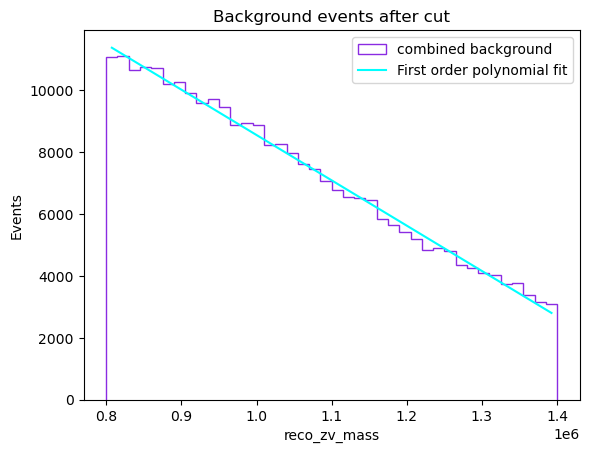

In [57]:
plt.hist(bgn_range["reco_zv_mass"] , bins = 40,label='combined background',weights =bgn_range["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.legend(loc='upper right')
plt.plot(Bxcenters, first_poly(Bxcenters, *m_comb_0.values), label = "First order polynomial fit", color = "aqua")
plt.legend(loc='upper right')
plt.title("Background events after cut")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

The firstr polynomial seems to be describing the background ok, but the chi^2 value is not very low (4.14) so I'm going to try a second order polynomial and compare the minimum chi^2 value and see which one is a better fit.

In [58]:
def second_poly (x, a, b,c):
    
    second_poly = a + b*x + c*x**2 
   
    
    return second_poly

In [59]:
def chi_second(a,b,c):
    
    z = np.sum((bgn_range["FullEventWeight"].values)**2)
    x = Bxcenters
    y = BAn
    
    
    return np.sum((y - second_poly(x,a,b,c))**2 / z )

In [60]:
# Estimate best value using Minuit

m_comb_1 = Minuit(chi_second, a = 1000, b = -100, c = 100)

# m_comb_0.errordef = Minuit.LIKELIHOOD
m_comb_1.migrad()  # run optimiser
m_comb_1.hesse()   # run covariance estimator

print(m_comb_1.values)  # print estimated values
print(m_comb_1.errors)  # print error of the estimated values

<ValueView a=24843.793331457884 b=-0.017701686970078345 c=1.3858091829819653e-09>
<ErrorView a=5879.322313123065 b=0.010873074991297358 c=4.930137237268578e-09>


In [61]:
# min chi^2 value
print(m_comb_1.fval)

2.09858841932013


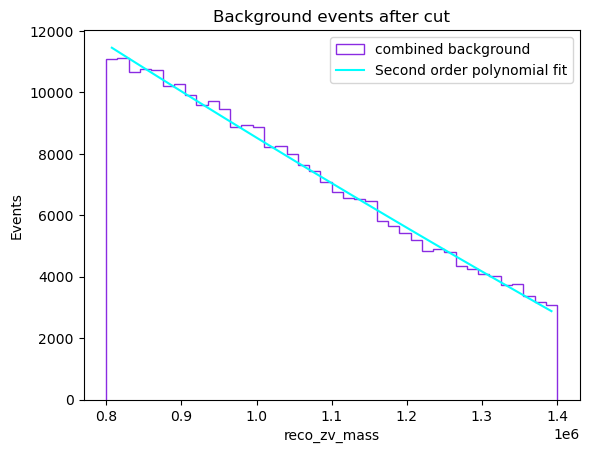

In [62]:
plt.hist(bgn_range["reco_zv_mass"] , bins = 40,label='combined background',weights =bgn_range["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.legend(loc='upper right')
plt.plot(Bxcenters, second_poly(Bxcenters, *m_comb_1.values), label = "Second order polynomial fit", color = "aqua")
plt.legend(loc='upper right')
plt.title("Background events after cut")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

In [63]:
print("Chi^2 fisrt order polynomial: " + str(m_comb_0.fval))
print("Chi^2 second order polynomial: " + str(m_comb_1.fval))

Chi^2 fisrt order polynomial: 2.1775963656097104
Chi^2 second order polynomial: 2.09858841932013


The chi^2 value is lower for the second order polynomial so I'm going to stick with that to model the background.

Now fit the signal with a single simple Gaussian first:

In [64]:
sig_range = data_gg_cut[(data_gg_cut["reco_zv_mass"] > 0.8e6) &(data_gg_cut["reco_zv_mass"] < 1.4e6)]

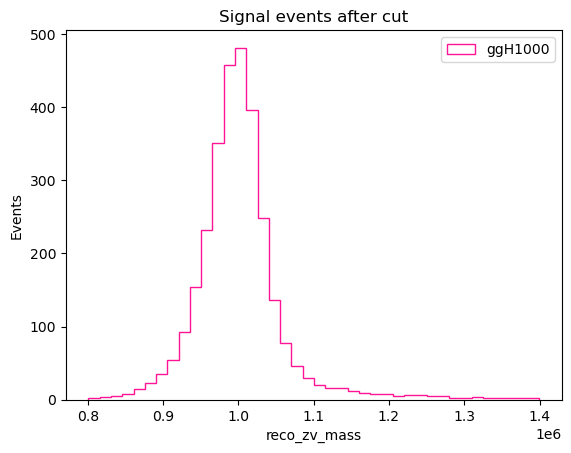

In [65]:
SAn, SAbins, SApatches = plt.hist(sig_range["reco_zv_mass"], bins = 40,label='ggH1000',weights =sig_range["FullEventWeight"],color = "deeppink",histtype=u'step')
plt.legend(loc='upper right')
plt.title("Signal events after cut")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

In [66]:
Sxcenters = (SAbins[:-1] + SAbins[1:]) / 2

In [67]:
def gaussian (x,a, mu, sigma):
    fun = a * np.exp(-(x - mu)**2 / (2*sigma**2))
    return  fun

In [68]:
def chi_gaussian(a,mu,sigma):
    
    z = np.sum((sig_range["FullEventWeight"].values)**2)
    x = Sxcenters
    y = SAn
    
    
    return np.sum((y - gaussian(x,a,mu,sigma))**2 / z )

In [69]:
# Estimate best value using Minuit

m_comb_2 = Minuit(chi_gaussian, a = 1000, mu = 1e6, sigma = 1e6)

# m_comb_0.errordef = Minuit.LIKELIHOOD
m_comb_2.migrad()  # run optimiser
m_comb_2.hesse()   # run covariance estimator

print(m_comb_2.values)  # print estimated values
print(m_comb_2.errors)  # print error of the estimated values

<ValueView a=465.55283723756554 mu=996442.1436003901 sigma=34909.64278200809>
<ErrorView a=11.531018906454593 mu=964.5781591273302 sigma=1066.3775069945173>


In [70]:
# min chi^2 value
print(m_comb_2.fval)

21.43892577381972


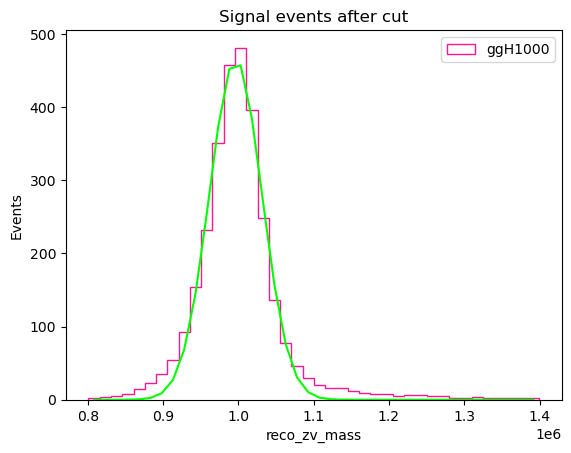

In [71]:
plt.hist(sig_range["reco_zv_mass"], bins = 40,label='ggH1000',weights =sig_range["FullEventWeight"],color = "deeppink",histtype=u'step')
plt.legend(loc='upper right')
plt.plot(Sxcenters, gaussian(Sxcenters, *m_comb_2.values), label = "Gaussian fit", color = "lime")
plt.title("Signal events after cut")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

Like for the background, this first model with a single simple Gaussian looks fine, but the chi^2 value is quite large  (It will probably fit better with a double sided crystal ball...)

Now I'm going to model the joint signal plus background mass spectrum with a weighthed sum of the single simple Gaussian and the second order polynomial. I first plot the distributions for only the background and for the background plus signal where we can see how small the peak looks.

In [72]:
combined_signal_cut = np.concatenate((data_bgn_cut, data_gg_cut))
data_combined_cut = pd.DataFrame(combined_signal_cut, columns = variables)

In [73]:
comb_range = data_combined_cut[(data_combined_cut["reco_zv_mass"] > 0.8e6) &(data_combined_cut["reco_zv_mass"] < 1.4e6)]

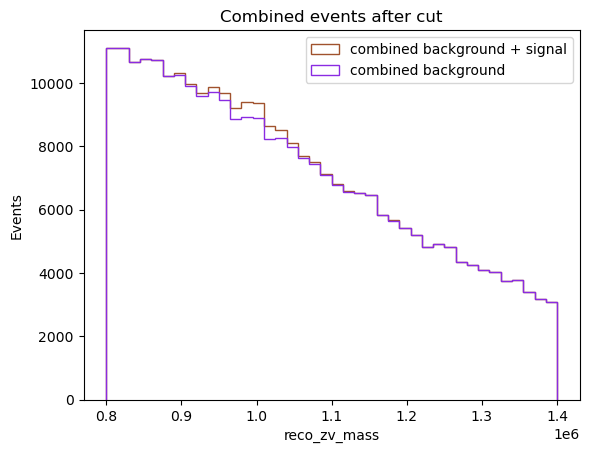

In [74]:
Cn, Cbins, Cpatches = plt.hist(comb_range["reco_zv_mass"] , bins = 40,label='combined background + signal',weights =comb_range["FullEventWeight"],color = "sienna",histtype=u'step')
plt.hist(bgn_range["reco_zv_mass"] , bins = 40,label='combined background',weights =bgn_range["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.legend(loc='upper right')
plt.title("Combined events after cut")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

In [75]:
Cxcenters = (Cbins[:-1] + Cbins[1:]) / 2

The fit is going to have the fractions and the background paramters as free floats and the Gaussian ones are going to be set with the ones obtained when the signal was mdoelled before.

In [76]:
def joint (x, K, a, b, c):
    
    l = m_comb_2.values[0]
    mu = m_comb_2.values[1]
    sigma = m_comb_2.values[2]
    gaussian = l *np.exp(-(x - mu)**2 / (2*sigma**2))
    
    pol = a + b*x + c*x**2 
    
    y = gaussian +  K*pol
    
    return y

In [77]:
def chi_joint(K, a, b, c):
    
    z = np.sum((comb_range["FullEventWeight"].values)**2)
    x = Cxcenters
    y = Cn
    
    
    return np.sum((y - joint (x, K, a, b, c))**2 / z )

In [78]:
# Estimate best value using Minuit

m_comb_4 = Minuit(chi_joint, K = 0.01, a = m_comb_1.values[0], b = m_comb_1.values[1] , c = m_comb_1.values[2] )

# m_comb_0.errordef = Minuit.LIKELIHOOD
m_comb_4.migrad()  # run optimiser
m_comb_4.hesse()   # run covariance estimator

print(m_comb_4.values)  # print estimated values
print(m_comb_4.errors)  # print error of the estimated values

<ValueView K=0.8976182816614823 a=24848.885366540104 b=-0.014611323887187343 c=-7.354918733671857e-10>
<ErrorView K=0.15218818996179656 a=7541.975799493001 b=0.01222395612536004 c=5.51694582457632e-09>


In [79]:
# min chi^2 value
print(m_comb_4.fval)

2.3509957902450997


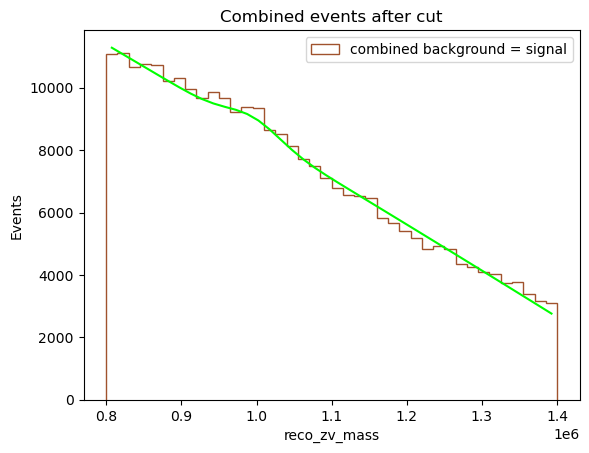

In [80]:
plt.hist(comb_range["reco_zv_mass"] , bins = 40,label='combined background = signal',weights =comb_range["FullEventWeight"],color = "sienna",histtype=u'step')
plt.legend(loc='upper right')
plt.plot(Cxcenters, joint(Cxcenters, *m_comb_4.values), label = "joint fit", color = "lime")
plt.title("Combined events after cut")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

The joint fit looks ok with an ok value for the chi^2 (1.70).

**This joint fit with a Gaussian for the signal corresponds to the H1 hypothesis.**

Then to make a quantitative analysis about how much better this H1 model is compared to a backgroun-only model (**H0**) we have to compare the corresponding chi^2 for both scenarios. Doing now the H0 fit (fitting only background model in the background + signal distribution):

In [81]:
# Estimate best value using Minuit

m_comb_5 = Minuit(chi_joint, K = 0.01, a = m_comb_1.values[0], b = m_comb_1.values[1] , c = m_comb_1.values[2] )

# m_comb_0.errordef = Minuit.LIKELIHOOD
m_comb_4.migrad()  # run optimiser
m_comb_4.hesse()   # run covariance estimator

print(m_comb_4.values)  # print estimated values
print(m_comb_4.errors)  # print error of the estimated values

<ValueView K=0.9044489383770569 a=27498.473128735342 b=-0.019599864659878657 c=1.5390032720601856e-09>
<ErrorView K=0.1038176556249172 a=2021.1214354935844 b=0.0017249835092276874 c=1.189087161407099e-09>


In [82]:
# Estimate best value using Minuit

m_comb_5 = Minuit(chi_second, a = 1000, b = -100, c = 100)

# m_comb_0.errordef = Minuit.LIKELIHOOD
m_comb_5.migrad()  # run optimiser
m_comb_5.hesse()   # run covariance estimator

print(m_comb_5.values)  # print estimated values
print(m_comb_5.errors)  # print error of the estimated values

<ValueView a=24843.793331457884 b=-0.017701686970078345 c=1.3858091829819653e-09>
<ErrorView a=5879.322313123065 b=0.010873074991297358 c=4.930137237268578e-09>


In [83]:
# min chi^2 value
print(m_comb_5.fval)

2.09858841932013


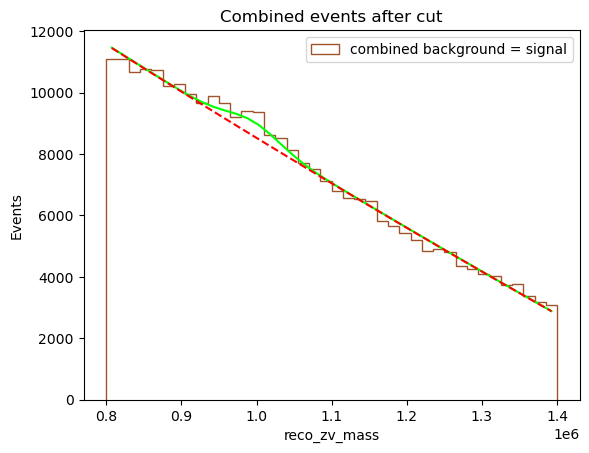

In [84]:
plt.hist(comb_range["reco_zv_mass"] , bins = 40,label='combined background = signal',weights =comb_range["FullEventWeight"],color = "sienna",histtype=u'step')
plt.legend(loc='upper right')
plt.plot(Cxcenters, joint(Cxcenters, *m_comb_4.values), label = "H1 fit", color = "lime")
plt.plot(Cxcenters, second_poly(Cxcenters, *m_comb_5.values), label = "H0 fit", color = "red", linestyle = "dashed")
plt.title("Combined events after cut")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

In [85]:
difchi = m_comb_5.fval - m_comb_4.fval

In [86]:
print("Difference chi^2H1 - chi^2H0 = " + str(difchi))

Difference chi^2H1 - chi^2H0 = 0.013147619826524348


According to Wilk's theorem the difference in chi^2 between H1 and H0 follows a chi^2 distribution, with
the number of degrees of freedom equal to the number of extra free parameters between
the H1 and H0 fits. The difference in the number of degress of freedom between the two models is just one
(the size of the signal contribution). Keeping in mind then Wilks theorem and the 1 degree of freedom I can then calculate the p and z value:

In [87]:
dof = 1 # 1 degree of freedom as only one parameter change between the two fits

p_value_diff = 1-chi2.cdf(difchi,dof) # calculate p-value using chi square cdf
n_sigmas_diff = erfinv(1-p_value_diff)*np.sqrt(2)
print("P value = "+str(p_value_diff))
print("Z value = "+str(n_sigmas_diff)+" sigma")



P value = 0.9087121859686018
Z value = 0.11466307089261282 sigma


The Z value ("amount of sigmas") is very low (still positive) which means that the result is not statistically that significant. It does not highly prove that we can detect a signal among the background. In particle physics real experiments to "claim" a signal between noise you will need at least 5 sigmas.

**Possible sources of imporvement:** Main thing would be trying to improve the cuts. Also a double sided crystal ball instead of a single simple Gaussian will define the signal peak probably better.

## Employing a NN classifier

For this next part I am going to use a Neural Network classifier to do the classification. The first question would be which data I am going to use (cut data or un-cut or something in between). For my first trial I'm going to use un-cut data. This is because I feel like the distributions for the kinematic variables differ more before the cuts, so it will be easier for my model to detect those differences. For example, the Zll_mass variable will not give any information to differentiate between signal or background after the cuts, but it is pretty significant before the cuts to detect top-background data (distributions before and after the cuts below):

Text(0.5, 0, 'Zll_mass')

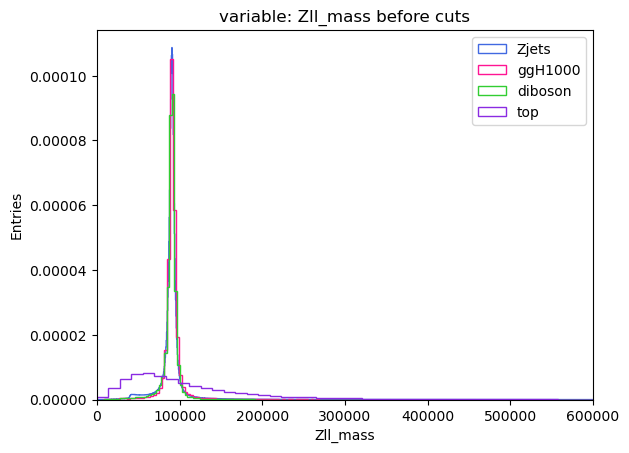

In [88]:
plt.hist(data_zjets["Zll_mass"], bins = 10000,  label='Zjets',histtype=u'step', density = True, color = "royalblue")
plt.hist(data_gg["Zll_mass"], bins = 200,  label='ggH1000',histtype=u'step', density = True, color = "deeppink")
plt.hist(data_diboson["Zll_mass"], bins = 500, label='diboson',histtype=u'step', density = True, color = "limegreen")
plt.hist(data_top["Zll_mass"], bins = 200, label = "top",histtype=u'step', density = True, color = "blueviolet")
plt.legend(loc='upper right')
plt.xlim((0,0.6e6))
plt.title("variable: Zll_mass before cuts")
plt.ylabel("Entries")
plt.xlabel("Zll_mass")


Text(0.5, 0, 'Zll_mass')

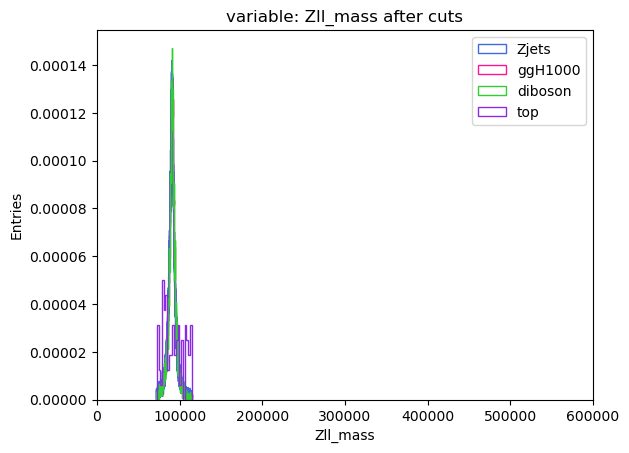

In [89]:
plt.hist(data_zjets_cut["Zll_mass"], bins = 10000,  label='Zjets',histtype=u'step', density = True, color = "royalblue")
plt.hist(data_gg_cut["Zll_mass"], bins = 200,  label='ggH1000',histtype=u'step', density = True, color = "deeppink")
plt.hist(data_diboson_cut["Zll_mass"], bins = 500, label='diboson',histtype=u'step', density = True, color = "limegreen")
plt.hist(data_top_cut["Zll_mass"], bins = 20, label = "top",histtype=u'step', density = True, color = "blueviolet")
plt.legend(loc='upper right')
plt.xlim((0,0.6e6))
plt.title("variable: Zll_mass after cuts")
plt.ylabel("Entries")
plt.xlabel("Zll_mass")


**Creating NN classifier model:**

In [90]:
num_outputs = 1 

In [91]:
def my_model(num_inputs , num_nodes , extra_depth): # create model
    model = Sequential ()
    model.add(Dense(num_nodes , input_dim=num_inputs , kernel_initializer='normal', activation='relu')) 
    model.add(Dropout(0.2))
    for i in range(extra_depth):
        
        model.add(Dense(num_nodes,input_dim=num_inputs*5,kernel_initializer = 'normal',activation='relu'))

    model.add(Dense(num_outputs , activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    return model

Try running the NN with a batch size of 500, 50 epochs, 20 nodes per layer, and extra depth = 1 as a starting point.

In [92]:
batch_size = 500
n_epochs = 50
num_nodes = 20 # per layer
extra_depth = 1 
number_inputs = 8

In [93]:
# compiled model
model = my_model(number_inputs,num_nodes,extra_depth)

**Prepare trainning data sets:**

In [94]:
seed = 88 # fixed random seed for reproducibility
data_bgn = sklearn.utils.shuffle(data_bgn,random_state=seed)
data_bgn = data_bgn.reset_index(drop=True)

We want to train with 50% signal and 50% background entries:

In [95]:
num = data_gg.shape[0]

In [96]:
x_train = pd.concat([data_gg, data_bgn[:num]],ignore_index=True) 
x_train = sklearn.utils.shuffle(x_train,random_state=seed)
x_train = x_train.reset_index(drop=True)

In [97]:
x_train.shape

(100026, 11)

In [98]:
# ignoring reco_zv_mass and FullEventWeight:
input_var = ['lep1_pt','lep2_pt','fatjet_pt','fatjet_eta','fatjet_D2','Zll_mass','Zll_pt','MET']
in_out_var = ['lep1_pt','lep2_pt','fatjet_pt','fatjet_eta','fatjet_D2','Zll_mass','Zll_pt','MET', "isSignal"]

In [99]:
# have the xt_train data set for the input and ouput variables (in_out_var)
new_xtrain = x_train[in_out_var]

Now we perform input-feature scaling. We then split the dataset into training (70%) and test (30%) subsets:

In [100]:
sc = preprocessing.StandardScaler()
input_data = sc.fit_transform(new_xtrain[input_var])
# set random seed
Answer_to_all_questions = 42
# train -test split of dataset
train_data, test_data, train_target, test_target = model_selection.train_test_split(input_data, new_xtrain["isSignal"], test_size=0.3, random_state=Answer_to_all_questions)
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(70018, 8) (70018,) (30008, 8) (30008,)


**The model is already compiled so now we train it:**

In [101]:
history = model.fit(train_data , train_target , batch_size=batch_size , epochs=n_epochs , verbose=1, validation_data=(test_data , test_target))

Epoch 1/50
141/141 [==============================] - 1s 4ms/step - loss: 0.4923 - accuracy: 0.8339 - val_loss: 0.3412 - val_accuracy: 0.8709
Epoch 2/50
141/141 [==============================] - 0s 2ms/step - loss: 0.3253 - accuracy: 0.8744 - val_loss: 0.3100 - val_accuracy: 0.8791
Epoch 3/50
141/141 [==============================] - 0s 2ms/step - loss: 0.3093 - accuracy: 0.8770 - val_loss: 0.2990 - val_accuracy: 0.8803
Epoch 4/50
141/141 [==============================] - 0s 2ms/step - loss: 0.3042 - accuracy: 0.8782 - val_loss: 0.2930 - val_accuracy: 0.8821
Epoch 5/50
141/141 [==============================] - 0s 2ms/step - loss: 0.3000 - accuracy: 0.8815 - val_loss: 0.2876 - val_accuracy: 0.8857
Epoch 6/50
141/141 [==============================] - 0s 2ms/step - loss: 0.2967 - accuracy: 0.8833 - val_loss: 0.2843 - val_accuracy: 0.8874
Epoch 7/50
141/141 [==============================] - 0s 2ms/step - loss: 0.2942 - accuracy: 0.8837 - val_loss: 0.2828 - val_accuracy: 0.8878
Epoch 

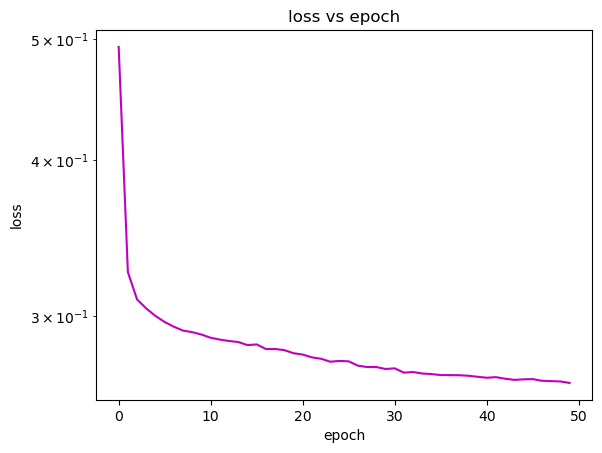

In [102]:
plt.plot(history.history['loss'], "m")
plt.title('loss vs epoch')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.show()

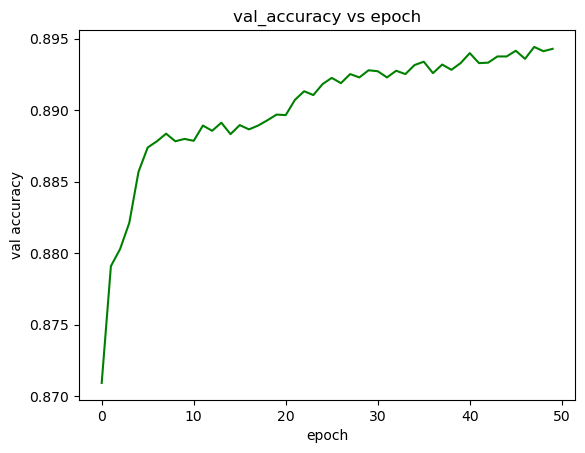

In [103]:
plt.plot(history.history['val_accuracy'], "g")
plt.title('val_accuracy vs epoch')
plt.xlabel("epoch")
plt.ylabel("val accuracy")
plt.show()

In [104]:
print(history.history['loss'][-1])

0.26526927947998047


In [105]:
print(history.history['val_accuracy'][-1])

0.8942948579788208


After looking at the plots there is no sign of overtrainning: the validation accuracy increases while the loss decreasses. The accuracy at the end is of 89%. We can try to change the architecture (adding a callback to choose number of epoch optimum) to increase this accuracy value.

In [106]:
batch_size = 500
n_epochs = 100
num_nodes = 50
extra_depth = 5
number_inputs = 8

In [107]:
# compiled model
model2 = my_model(number_inputs,num_nodes,extra_depth)

In [108]:
callbacks_ = [
# if we don’t have an increase of the accuracy for 10 epochs, terminate training. 
EarlyStopping(verbose=True, patience=10, monitor="val_accuracy"),
# Always make sure that we’re saving the model weights with the best accuracy. 
ModelCheckpoint("model.h5",monitor="val_accuracy", save_best_only=True, mode="max")]

history2 = model2.fit(train_data , train_target , batch_size=batch_size , epochs= n_epochs , verbose=1, validation_data=(test_data , test_target), callbacks=callbacks_)

Epoch 1/100
141/141 [==============================] - 1s 5ms/step - loss: 0.4182 - accuracy: 0.8329 - val_loss: 0.2916 - val_accuracy: 0.8844
Epoch 2/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2884 - accuracy: 0.8859 - val_loss: 0.2782 - val_accuracy: 0.8891
Epoch 3/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2820 - accuracy: 0.8874 - val_loss: 0.2733 - val_accuracy: 0.8909
Epoch 4/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2779 - accuracy: 0.8896 - val_loss: 0.2814 - val_accuracy: 0.8880
Epoch 5/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2775 - accuracy: 0.8900 - val_loss: 0.2680 - val_accuracy: 0.8929
Epoch 6/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2720 - accuracy: 0.8910 - val_loss: 0.2655 - val_accuracy: 0.8918
Epoch 7/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2694 - accuracy: 0.8917 - val_loss: 0.2642 - val_accuracy: 0.8927

Epoch 58/100
141/141 [==============================] - 1s 4ms/step - loss: 0.2483 - accuracy: 0.9003 - val_loss: 0.2459 - val_accuracy: 0.9012
Epoch 59/100
141/141 [==============================] - 1s 4ms/step - loss: 0.2494 - accuracy: 0.9000 - val_loss: 0.2451 - val_accuracy: 0.9018
Epoch 60/100
141/141 [==============================] - 1s 4ms/step - loss: 0.2481 - accuracy: 0.9010 - val_loss: 0.2455 - val_accuracy: 0.9006
Epoch 60: early stopping


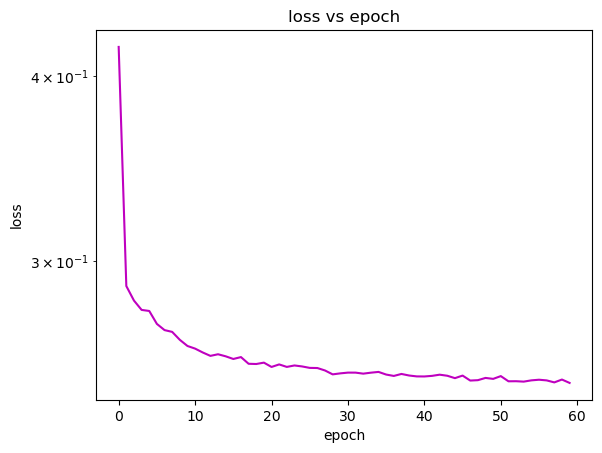

In [109]:
plt.plot(history2.history['loss'], "m")
plt.title('loss vs epoch')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.show()

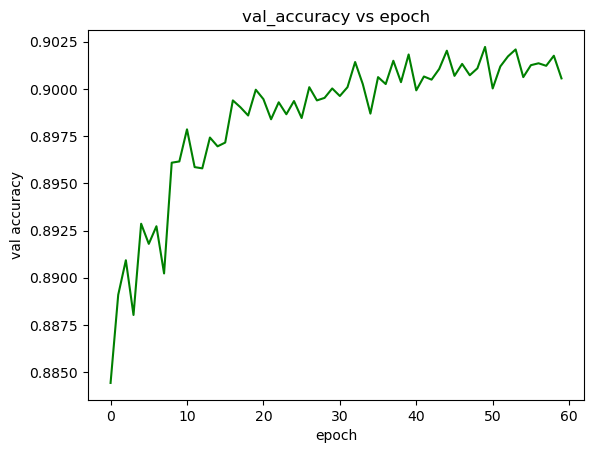

In [110]:
plt.plot(history2.history['val_accuracy'], "g")
plt.title('val_accuracy vs epoch')
plt.xlabel("epoch")
plt.ylabel("val accuracy")
plt.show()

In [111]:
print(history2.history['loss'][-1])

0.2481383979320526


In [112]:
print(history2.history['val_accuracy'][-1])

0.9005598425865173


The accuracy is higher than for the previous model and the final loss is lower so i am going to stick with this second model.

In [113]:
test_pred = model2.predict(test_data)

938/938 [==============================] - 1s 894us/step


In [114]:
test_target.values

array([1., 0., 0., ..., 0., 0., 1.])

In [115]:
test_pred[:,0]

array([0.75156385, 0.11308446, 0.3213171 , ..., 0.01230712, 0.04113034,
       0.9862566 ], dtype=float32)

Comparing the values at first glance they look ok.

(array([11123.,  1662.,   894.,   705.,   729.,   832.,   874.,  1146.,
         1984., 10059.]),
 array([8.70423497e-17, 9.94401202e-02, 1.98880240e-01, 2.98320353e-01,
        3.97760481e-01, 4.97200608e-01, 5.96640706e-01, 6.96080863e-01,
        7.95520961e-01, 8.94961119e-01, 9.94401217e-01]),
 <BarContainer object of 10 artists>)

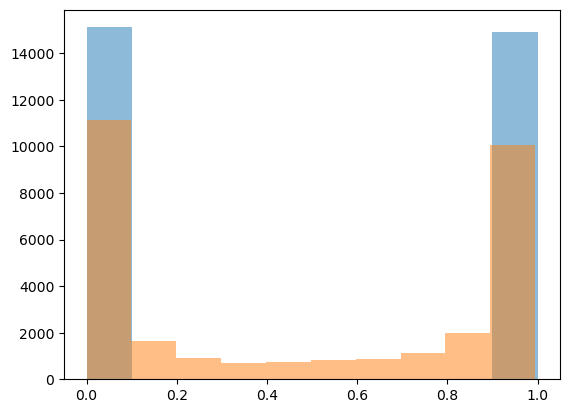

In [183]:
# check the distribution of predicted isSignal
plt.hist(test_target.values, alpha = 0.5)
plt.hist(test_pred, alpha = 0.5)

Running the prediction of the model on the full (un-cut) data:

In [117]:
# combinning all the entries
tot = np.concatenate((data_zjets, data_diboson, data_top, data_gg))
data_tot = pd.DataFrame(tot, columns = variables)

In [118]:
target_tot = data_tot["isSignal"].values

In [119]:
input_tot = sc.transform(data_tot[input_var])

In [120]:
predicted_tot = model2.predict(input_tot)

214906/214906 [==============================] - 225s 1ms/step


In [121]:
final_pred = pd.DataFrame(input_tot, columns = input_var)

In [122]:
final_pred["isSignalPred"] = predicted_tot.flatten().tolist()
final_pred["reco_zv_mass"] =data_tot["reco_zv_mass"].values.tolist()
final_pred["FullEventWeight"] =data_tot["FullEventWeight"].values.tolist()
final_pred["isSignal"] =data_tot["isSignal"].values.tolist()

In [123]:
final_pred.head()

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,isSignalPred,reco_zv_mass,FullEventWeight,isSignal
0,-1.020334,-1.263953,-1.227233,-1.382429,0.015299,0.125728,-1.318874,1.415026,0.011363,596020.44,-0.790471,0.0
1,-1.254653,-1.027668,-1.115868,-0.447767,-0.622040,-0.064880,-1.486894,-0.311977,0.000941,260357.19,0.789204,0.0
2,-1.140648,-1.035553,1.076266,-0.566873,0.206311,0.030445,-1.366323,6.372155,0.081525,422698.44,-0.872639,0.0
3,-1.157653,-0.661611,-1.293662,1.841355,0.077870,-0.088930,-1.323358,0.007668,0.018018,302718.06,-0.772697,0.0
4,-1.072176,-1.017612,-0.443522,-1.584563,0.158734,-0.068067,-1.409195,0.010173,0.011457,461896.25,1.581337,0.0


In [124]:
data_tot.head()

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,76128.370,11973.011,210397.60,-1.329446,1.895164,95697.766,64252.690,177227.420,596020.44,0.0,-0.790471
1,40799.945,27624.867,226681.30,-0.429050,0.000000,90289.914,32506.705,10660.757,260357.19,0.0,0.789204
2,57988.660,27102.590,547212.70,-0.543789,2.463149,92994.430,55287.625,655334.400,422698.44,0.0,-0.872639
3,55424.742,51873.030,200684.47,1.776149,2.081222,89607.580,63405.484,41489.973,302718.06,0.0,-0.772697
4,68312.220,28290.979,324990.97,-1.524169,2.321676,90199.480,47187.332,41731.630,461896.25,0.0,1.581337


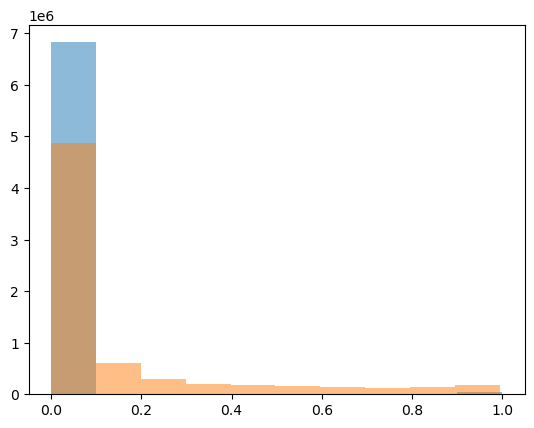

In [125]:
plt.hist(data_tot["isSignal"],  alpha = 0.5)
plt.hist(final_pred["isSignalPred"],  alpha = 0.5)
plt.show()

So far it looks sensible

In [126]:
cut_on_pred = final_pred[final_pred.isSignalPred >= 0.5]

The background looks less linear than before. I am going to do the fits and compare with cuts results.

In [127]:
pred_range = cut_on_pred[(cut_on_pred["reco_zv_mass"] > 0.8e6) &(cut_on_pred["reco_zv_mass"] < 1.4e6)]

In [128]:
# combinning all the entries after cuts
cut_tot = np.concatenate((data_zjets_cut, data_diboson_cut, data_top_cut, data_gg_cut))
cut_tot = pd.DataFrame(cut_tot, columns = variables)
cut_range = cut_tot[(cut_tot["reco_zv_mass"] > 0.8e6) &(cut_tot["reco_zv_mass"] < 1.4e6)]

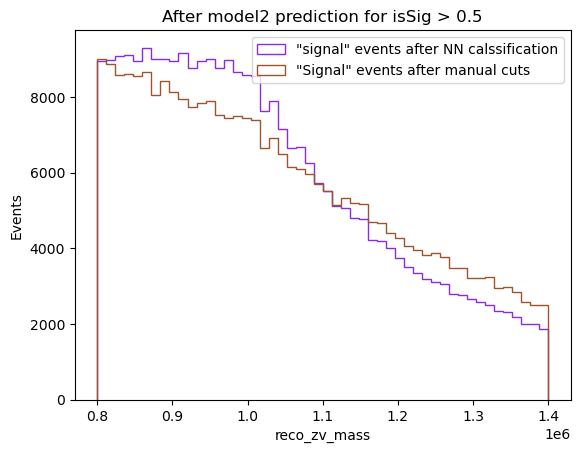

In [129]:
n1, bins1, patches1 = plt.hist(pred_range["reco_zv_mass"] , bins = 50,label='"signal" events after NN calssification',weights =pred_range["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.hist(cut_range["reco_zv_mass"], bins = 50, label = '"Signal" events after manual cuts', weights = cut_range["FullEventWeight"], color = "sienna",     histtype = u'step')       
plt.legend(loc='upper right')
plt.title("After model2 prediction for isSig > 0.5")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

In [130]:
xcenters1 = (bins1[:-1] + bins1[1:]) / 2

I can see a more prominent peak after the NN classification compared to the cuts doing by eye.

I am going to perform the modelling as before, by separating the actual signal using the original isSignal varible. First on Gaussian, then on background and lastly in joint.

In [131]:
sig_on_pred = cut_on_pred[(cut_on_pred["reco_zv_mass"] > 0.8e6) &(cut_on_pred["reco_zv_mass"] < 1.4e6) & (cut_on_pred.isSignal == 1)]

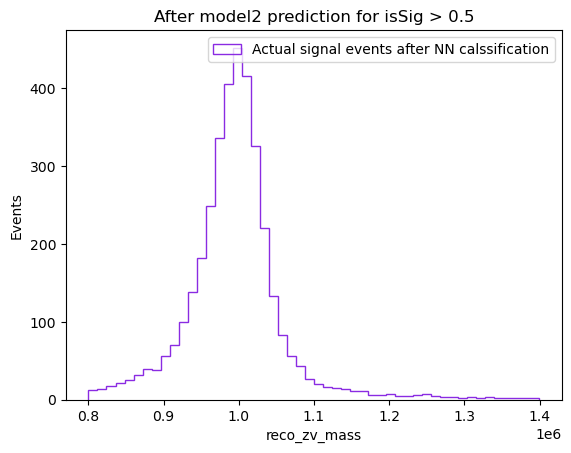

In [132]:
n2, bin2, patches2 = plt.hist(sig_on_pred["reco_zv_mass"] , bins = 50,label='Actual signal events after NN calssification',weights =sig_on_pred["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.legend(loc='upper right')
plt.title("After model2 prediction for isSig > 0.5")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

In [133]:
xcenters2 = (bin2[:-1] + bin2[1:]) / 2

In [134]:
def gaussian1 (x,a, mu, sigma):
    fun = a * np.exp(-(x - mu)**2 / (2*sigma**2))
    return  fun

In [135]:
def chi_gaussian1(a,mu,sigma):
    
    z = np.sum((sig_on_pred["FullEventWeight"].values)**2)
    x = xcenters2
    y = n2
    
    
    
    return np.sum((y - gaussian1(x,a,mu,sigma))**2 / z )

In [136]:
# Estimate best value using Minuit

m_comb_c = Minuit(chi_gaussian1, a = 1000, mu = 1e6, sigma = 1e6)

# m_comb_0.errordef = Minuit.LIKELIHOOD
m_comb_c.migrad()  # run optimiser
m_comb_c.hesse()   # run covariance estimator

print(m_comb_c.values)  # print estimated values
print(m_comb_c.errors)  # print error of the estimated values

<ValueView a=421.90974024509205 mu=995082.1915365951 sigma=36653.74322717701>
<ErrorView a=11.415976590564066 mu=1095.8025404970867 sigma=1250.33807841691>


In [137]:
# min chi^2 value
print(m_comb_c.fval)

36.262968621741656


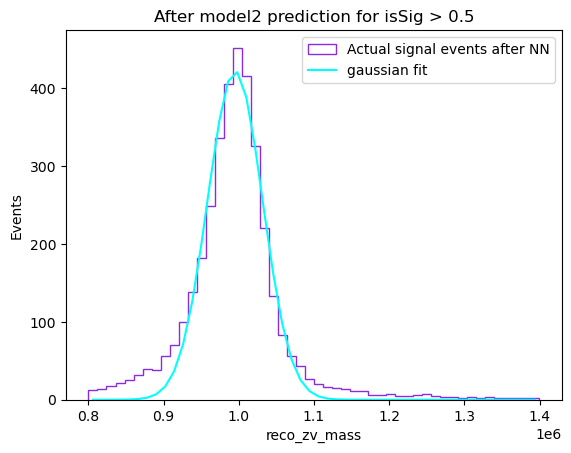

In [138]:
n2, bin2, patches2 = plt.hist(sig_on_pred["reco_zv_mass"] , bins = 50,label='Actual signal events after NN',weights =sig_on_pred["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.plot(xcenters2, gaussian1(xcenters2, *m_comb_c.values), label = "gaussian fit", color = "aqua" )
plt.legend(loc='upper right')
plt.title("After model2 prediction for isSig > 0.5")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

That looks ok so now I'm going to do the background:

In [139]:
bgn_on_pred = cut_on_pred[(cut_on_pred["reco_zv_mass"] > 0.8e6) &(cut_on_pred["reco_zv_mass"] < 1.4e6) & (cut_on_pred.isSignal == 0)]

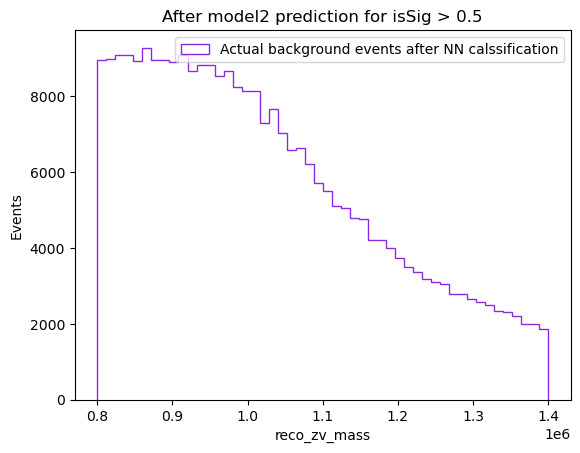

In [140]:
n3, bin3, patches3 = plt.hist(bgn_on_pred["reco_zv_mass"] , bins = 50,label='Actual background events after NN calssification',weights =bgn_on_pred["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.legend(loc='upper right')
plt.title("After model2 prediction for isSig > 0.5")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

In [141]:
xcenters3 = (bin3[:-1] + bin3[1:]) / 2

In [142]:
def third_poly (x, a, b,c, d):
    
    third = a + b*x + c*x**2  + d*x**3 
   
    
    return third

In [143]:
def chi_third(a,b,c, d):
    
    z = np.sum((bgn_on_pred["FullEventWeight"].values)**2)
    x = xcenters3
    y = n3
    
    
    return np.sum((y - third_poly(x,a,b,c, d))**2 / z )

In [144]:
# Estimate best value using Minuit

m_comb_b = Minuit(chi_third, a = 1000, b = -100, c = 100, d = 10)

# m_comb_0.errordef = Minuit.LIKELIHOOD
m_comb_b.migrad()  # run optimiser
m_comb_b.hesse()   # run covariance estimator

print(m_comb_b.values)  # print estimated values
print(m_comb_b.errors)  # print error of the estimated values

<ValueView a=-129610.22969697154 b=0.4077699577868654 c=-3.861381932176393e-07 d=1.1583848300484352e-13>
<ErrorView a=1027.999841746673 b=0.0014559945440860255 c=1.2390488283967217e-09 d=7.200514821690893e-16>


In [145]:
# min chi^2 value
print(m_comb_b.fval)

2.6889473369512187


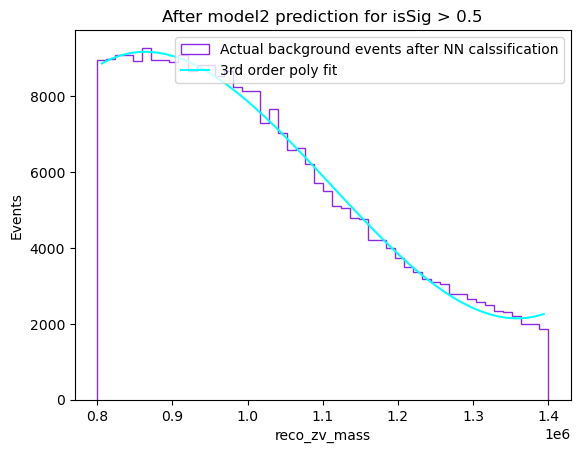

In [147]:
plt.hist(bgn_on_pred["reco_zv_mass"] , bins = 50,label='Actual background events after NN calssification',weights =bgn_on_pred["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.plot(xcenters3, third_poly(xcenters3, *m_comb_b.values), label = "3rd order poly fit", color = "aqua" )
plt.legend(loc='upper right')
plt.title("After model2 prediction for isSig > 0.5")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()



That also looks good, so now I am going to model the joint distributino using a simple single Gaussian and a 3rd order polynomial.

In [148]:
def joint1 (x, K, a, b, c, d):
    
    l = m_comb_c.values[0]
    mu = m_comb_c.values[1]
    sigma = m_comb_c.values[2]
    gaussian = l *np.exp(-(x - mu)**2 / (2*sigma**2))
    
    pol = a + b*x + c*x**2 + d*x**3
    
    y = gaussian +  K*pol
    
    return y

In [149]:
def chi_joint1(K, a, b, c, d):
    
    z = np.sum((pred_range["FullEventWeight"].values)**2)
    x = xcenters1
    y = n1
    
    
    return np.sum((y - joint1 (x, K, a, b, c, d))**2 / z )

In [150]:
# Estimate best value using Minuit

m_comb_a = Minuit(chi_joint1, K = 0.9, a = m_comb_b.values[0], b = m_comb_b.values[1] , c = m_comb_b.values[2] , d = m_comb_b.values[3])

# m_comb_0.errordef = Minuit.LIKELIHOOD
m_comb_a.migrad()  # run optimiser
m_comb_a.hesse()   # run covariance estimator

print(m_comb_a.values)  # print estimated values
print(m_comb_a.errors)  # print error of the estimated values

<ValueView K=0.9793505722819937 a=-129387.59292807944 b=0.407846600021438 c=-3.8617029217727777e-07 d=1.157431182137536e-13>
<ErrorView K=0.13884766204642296 a=46.91999654460747 b=4.3564422059730134e-05 c=4.239696780950563e-11 d=5.897627354111375e-16>


In [151]:
# min chi^2 value
print(m_comb_a.fval)

2.5897376544559085


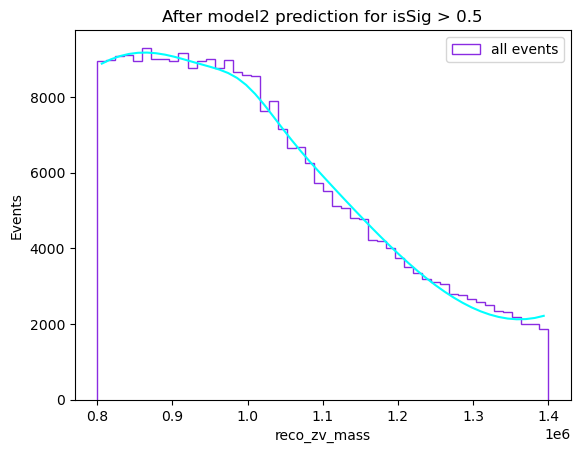

In [152]:
plt.hist(pred_range["reco_zv_mass"] , bins = 50,label='all events',weights =pred_range["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.legend(loc='upper right')
plt.plot(xcenters1, joint1(xcenters1, *m_comb_a.values), label = "joint fit", color = "aqua" )
plt.title("After model2 prediction for isSig > 0.5")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

That would be the fit model for the hypothesis **H1**. Now for the **H0** I fit the same distribution with only the polynomial to account for a case with no signal.

In [153]:
def chi_third2(a,b,c, d):
    
    
    z = np.sum((pred_range["FullEventWeight"].values)**2)
    x = xcenters1
    y = n1
    
    
    return np.sum((y - third_poly(x,a,b,c, d))**2 / z )

In [154]:
# Estimate best value using Minuit

m_comb_e = Minuit(chi_third2,  a = m_comb_b.values[0], b = m_comb_b.values[1] , c = m_comb_b.values[2] , d = m_comb_b.values[3])

# m_comb_0.errordef = Minuit.LIKELIHOOD
m_comb_e.migrad()  # run optimiser
m_comb_e.hesse()   # run covariance estimator

print(m_comb_e.values)  # print estimated values
print(m_comb_e.errors)  # print error of the estimated values

<ValueView a=-130156.38766557089 b=0.4085608332742867 c=-3.8573677480508084e-07 d=1.15315044919854e-13>
<ErrorView a=1028.29003091297 b=0.0014564073763455203 c=1.23939288721359e-09 d=7.202514803082388e-16>


In [155]:
# min chi^2 value
print(m_comb_e.fval)

4.7655489704953204


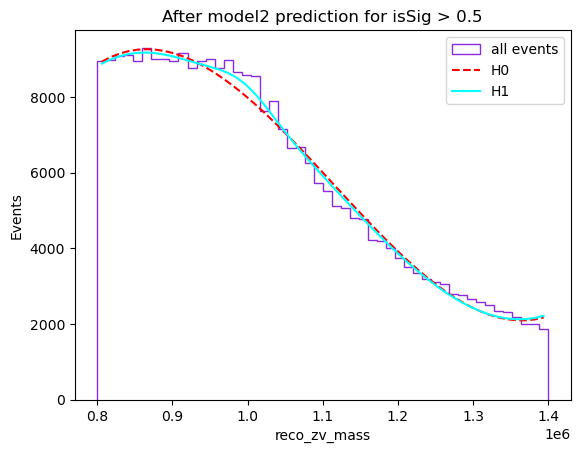

In [156]:
plt.hist(pred_range["reco_zv_mass"] , bins = 50,label='all events',weights =pred_range["FullEventWeight"],color = "blueviolet",histtype=u'step')

plt.plot(xcenters1, third_poly(xcenters1, *m_comb_e.values), label = "H0", color = "red", linestyle = "dashed" )
plt.plot(xcenters1, joint1(xcenters1, *m_comb_a.values), label = "H1", color = "aqua" )
plt.legend(loc='upper right')
plt.title("After model2 prediction for isSig > 0.5")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

In the plot the signal is not that evident by the chi^square difference between H0 and H1 seems bigger than when I did the cuts. So I am going to use Wilks theorem to see the significance. (Also visually we can also tell than a higher order polynomial for the background will model it better and -again- the signal peal tails look like would be better modelled by a double sided Crystal Ball). --- other ideas for bakground models can be found in this paper [2].

In [157]:
difchi2 = m_comb_e.fval - m_comb_a.fval

In [158]:
print("Difference chi^2H1 - chi^2H0 = " + str(difchi2))

Difference chi^2H1 - chi^2H0 = 2.175811316039412


According to Wilk's theorem the difference in chi^2 between H1 and H0 follows a chi^2 distribution, with
the number of degrees of freedom equal to the number of extra free parameters between
the H1 and H0 fits. The difference in the number of degress of freedom between the two models is just one
(the size of the signal contribution). Keeping in mind then Wilks theorem and the 1 degree of freedom I can then calculate the p and z value:

In [159]:
dof = 1 # 1 degree of freedom as only one parameter change between the two fits

p_value_diff = 1-chi2.cdf(difchi2,dof) # calculate p-value using chi square cdf
n_sigmas_diff = erfinv(1-p_value_diff)*np.sqrt(2)
print("P value = "+str(p_value_diff))
print("Z value = "+str(n_sigmas_diff)+" sigma")


P value = 0.14019556459100901
Z value = 1.475063156627356 sigma


The Z value ("amount of sigmas") (as for the cut by eye data case) is very low (still positive) which means that the result is not statistically that significant. It does not highly prove that we can detect a signal among the background. In particle physics real experiments to "claim" a signal between noise you will need at least 5 sigmas.

**Now**, comparing both methods, one trying to do classification by making square cuts in the kinematic distributions "by-eye" and the other one using a NN for the calssification, the Z value is higher by one order of magnitude with the NN approcach (1.4 for NN and 0.11 for the cuts). This proves that the NN has made a better job at distinguishing the signal, which is also shown when I plotted both "resulted" histograms together (replotted again below to swho them:

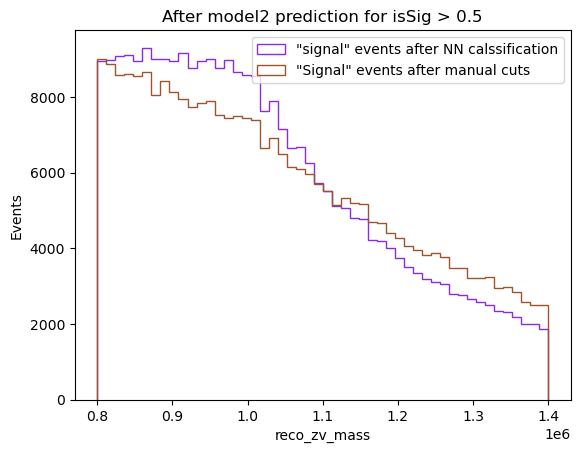

In [160]:
plt.hist(pred_range["reco_zv_mass"] , bins = 50,label='"signal" events after NN calssification',weights =pred_range["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.hist(cut_range["reco_zv_mass"], bins = 50, label = '"Signal" events after manual cuts', weights = cut_range["FullEventWeight"], color = "sienna",     histtype = u'step')       
plt.legend(loc='upper right')
plt.title("After model2 prediction for isSig > 0.5")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

## Impact of trainning sample on classifier

For this part I am going to proceed as before (using the model2 constructed) but now including reco_zv_mass as a trainning variable making it part of the input.

In [161]:
# ignoring reco_zv_mass and FullEventWeight:
input_var2 = ['lep1_pt','lep2_pt','fatjet_pt','fatjet_eta','fatjet_D2','Zll_mass','Zll_pt','MET', 'reco_zv_mass']
in_out_var2 = ['lep1_pt','lep2_pt','fatjet_pt','fatjet_eta','fatjet_D2','Zll_mass','Zll_pt','MET', "isSignal", 'reco_zv_mass']

In [162]:
# have the xt_train data set for the input and ouput variables (in_out_var)
new_xtrain2 = x_train[in_out_var2]

In [163]:
sc = preprocessing.StandardScaler()
input_data = sc.fit_transform(new_xtrain2[input_var2])
# set random seed
Answer_to_all_questions = 42
# train -test split of dataset
train_data, test_data, train_target, test_target = model_selection.train_test_split(input_data, new_xtrain2["isSignal"], test_size=0.3, random_state=Answer_to_all_questions)
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(70018, 9) (70018,) (30008, 9) (30008,)


In [164]:
batch_size = 500
n_epochs = 100
num_nodes = 50
extra_depth = 5
number_inputs = 9

In [165]:
# compiled model
model3 = my_model(number_inputs,num_nodes,extra_depth)

In [166]:
history3 = model3.fit(train_data , train_target , batch_size=batch_size , epochs= n_epochs , verbose=1, validation_data=(test_data , test_target), callbacks=callbacks_)

Epoch 1/100
141/141 [==============================] - 1s 5ms/step - loss: 0.3676 - accuracy: 0.8794 - val_loss: 0.1970 - val_accuracy: 0.9294
Epoch 2/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1927 - accuracy: 0.9312 - val_loss: 0.1798 - val_accuracy: 0.9357
Epoch 3/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1846 - accuracy: 0.9327 - val_loss: 0.1738 - val_accuracy: 0.9372
Epoch 4/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1782 - accuracy: 0.9358 - val_loss: 0.1702 - val_accuracy: 0.9383
Epoch 5/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1749 - accuracy: 0.9372 - val_loss: 0.1671 - val_accuracy: 0.9391
Epoch 6/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1715 - accuracy: 0.9380 - val_loss: 0.1664 - val_accuracy: 0.9384
Epoch 7/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1704 - accuracy: 0.9386 - val_loss: 0.1645 - val_accuracy: 0.9408

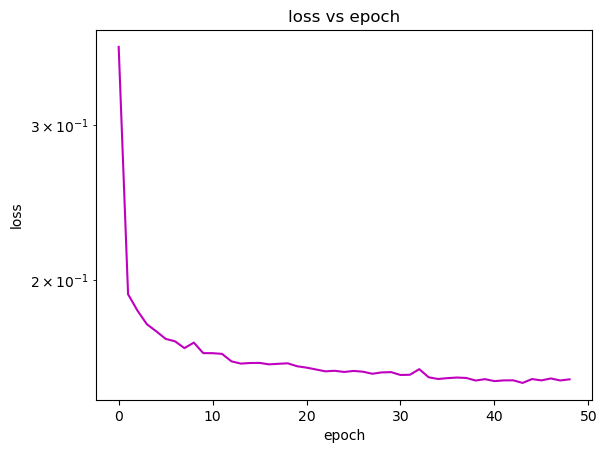

In [167]:
plt.plot(history3.history['loss'], "m")
plt.title('loss vs epoch')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.show()

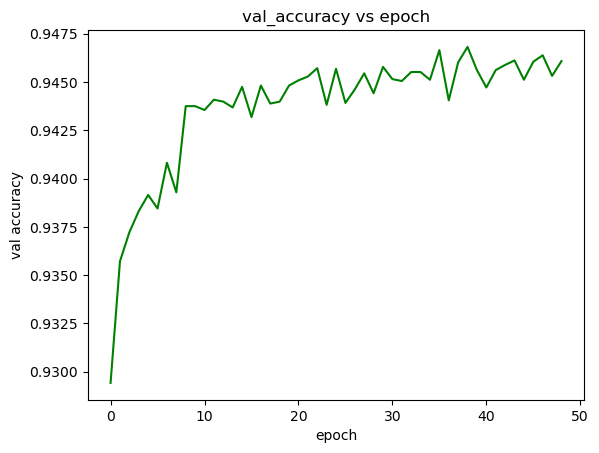

In [168]:
plt.plot(history3.history['val_accuracy'], "g")
plt.title('val_accuracy vs epoch')
plt.xlabel("epoch")
plt.ylabel("val accuracy")
plt.show()

In [169]:
print(history3.history['loss'][-1])
print(history3.history['val_accuracy'][-1])

0.15430523455142975
0.9460810422897339


After adding the new input variable to train and using the same model architecture the accuracy has gone up and the loss down (in comparison to before when the trainning data did not have reco_zv_mass).

In [170]:
input_tot2 = sc.transform(data_tot[input_var2])

In [171]:
predicted_tot2 = model3.predict(input_tot2)

214906/214906 [==============================] - 232s 1ms/step


In [172]:
final_pred2 = pd.DataFrame(input_tot2, columns = input_var2)

In [173]:
final_pred2["isSignalPred"] = predicted_tot2.flatten().tolist()
final_pred2["reco_zv_mass1"] =data_tot["reco_zv_mass"].values.tolist()
final_pred2["FullEventWeight"] =data_tot["FullEventWeight"].values.tolist()
final_pred2["isSignal"] =data_tot["isSignal"].values.tolist()

In [174]:
cut_on_pred2 = final_pred2[final_pred2.isSignalPred >= 0.5]

In [175]:
pred_range2 = cut_on_pred2[(cut_on_pred2["reco_zv_mass1"] > 0.8e6) &(cut_on_pred2["reco_zv_mass1"] < 1.4e6)]

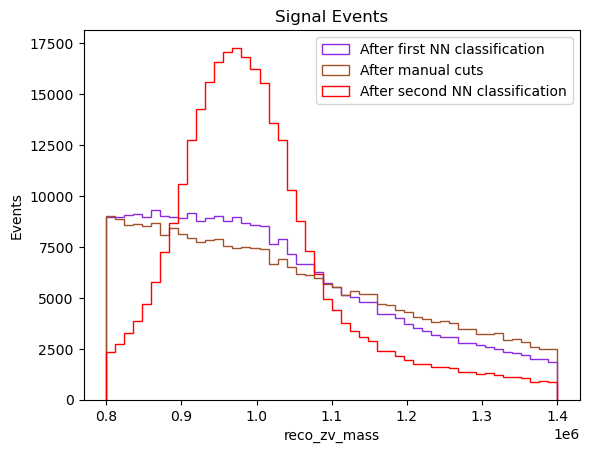

In [176]:
plt.hist(pred_range["reco_zv_mass"] , bins = 50,label='After first NN classification',weights =pred_range["FullEventWeight"],color = "blueviolet",histtype=u'step')
plt.hist(cut_range["reco_zv_mass"], bins = 50, label = 'After manual cuts', weights = cut_range["FullEventWeight"], color = "sienna",     histtype = u'step')       
plt.hist(pred_range2["reco_zv_mass1"] , bins = 50,label='After second NN classification',weights =pred_range2["FullEventWeight"],color = "red",histtype=u'step')
plt.legend(loc='upper right')
plt.title("Signal Events")
plt.xlabel("reco_zv_mass")
plt.ylabel("Events")
plt.show()

The signal is now way more visible than before compared to the two previous approaches.

If we go back to the beginning and plot again the kinematic distributions (before making any cuts or weights) (plotted again below) we can see how the reco_zv_mass variable is the one where the signal is more different to the background so it makes sense that by adding this variable to the NN trainning the model was able to classify the data better. In a similar way if during the cuts we cutted reco_zv_mass then of course it will be very easy to get a very nice isolated signal peak. 

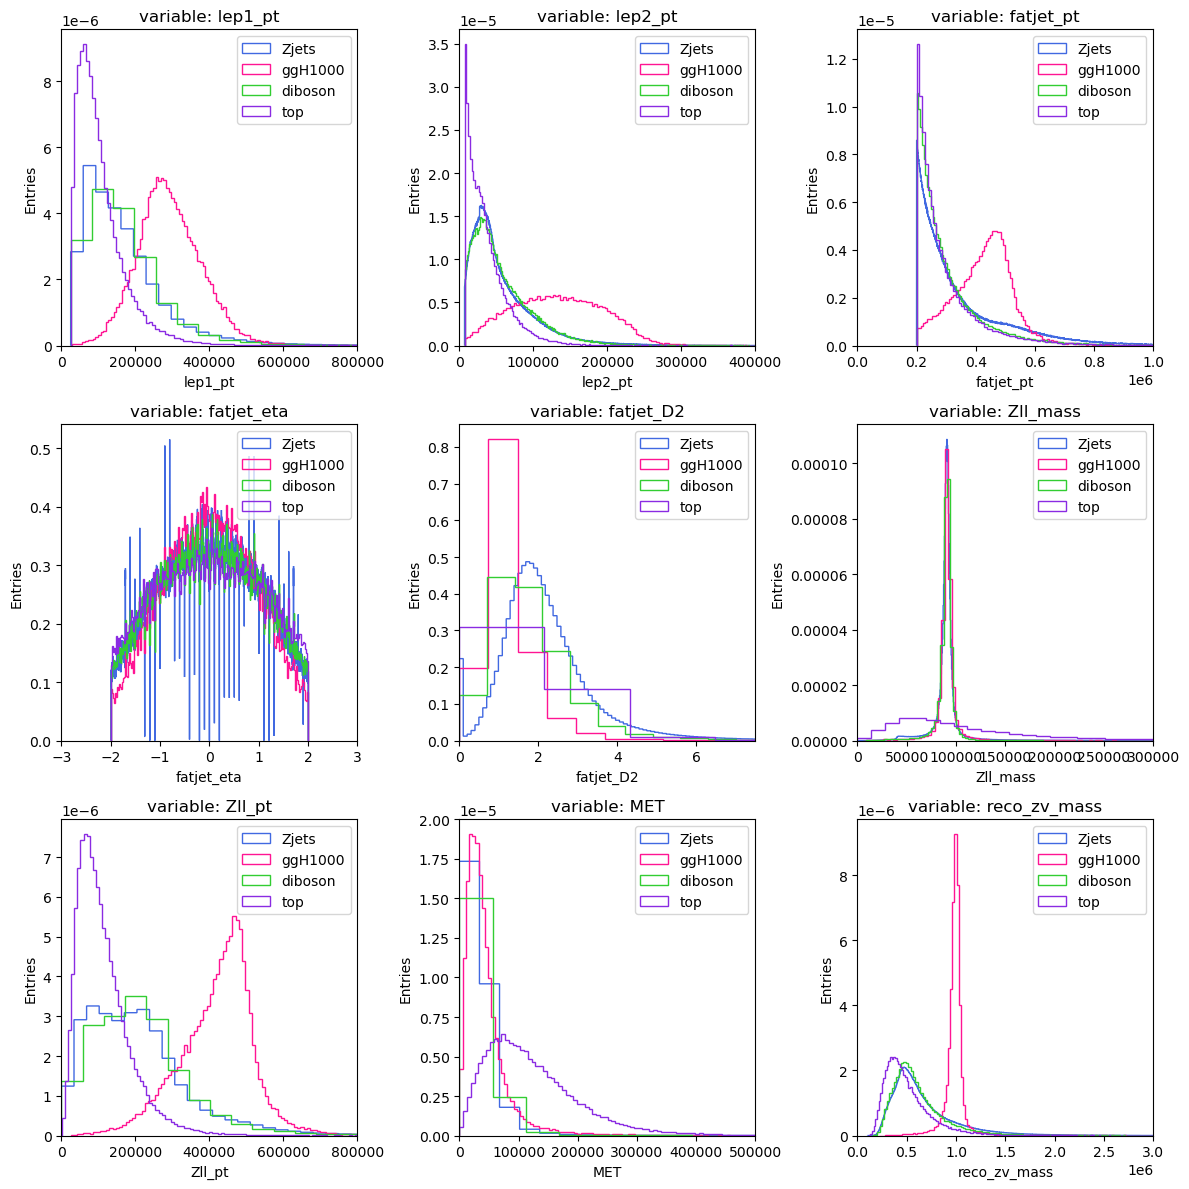

In [177]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace =0.2)
for i in range(1,10):
        ax = fig.add_subplot(3,3,i)
        ax.hist(data_zjets[variables[i-1]], bins = 10000,  label='Zjets',histtype=u'step', density = True, color = "royalblue")
        ax.hist(data_gg[variables[i-1]], bins = 200,  label='ggH1000',histtype=u'step', density = True, color = "deeppink")
        ax.hist(data_diboson[variables[i-1]], bins = 500, label='diboson',histtype=u'step', density = True, color = "limegreen")
        ax.hist(data_top[variables[i-1]], bins = 200, label = "top",histtype=u'step', density = True, color = "blueviolet")
        ax.legend(loc='upper right')
        ax.set_xlim((lim_down[i-1], lim_up[i-1]))
        ax.set_title("variable: " + str(variables[i-1]))
        ax.set_ylabel("Entries")
        ax.set_xlabel(str(variables[i-1]))
fig.tight_layout()

## References:
* [1] *"Introduction to elementary particle physics: Data Analysis Basics"* http://www.phys.ufl.edu/~korytov/phz6355/note_A13_statistics.pdf
* [2] *Background Modelling in the ATLAS H → γγ Differential Cross Section Analysis*
. Atlas collaboration. PoS.
https://cds.cern.ch/record/2783396/files/ATL-PHYS-PROC-2021-069.pdf